In [ ]:
# Import necessary modules
from predictor import get_predictor 
from utils.utils import rolling_predictor, plot_pmf_overlap
from config.loader import load_config
import pandas as pd
import numpy as np

# Change Point Detection and Prediction Experiment

This notebook runs change point detection and PMF prediction experiments for Cox/M/1 queuing systems.

## Available Configurations


- **Scenarios**: `'z5t1'`, `'z5t5'`, `'z80t1'`, `'z80t5'`
- **Methods**: `'kalman'`, `'cpd'`, `'cpd_bayesian'`

## Workflow
1. Configure experiment parameters
2. Load data
3. Run prediction
4. Save results
5. Generate PMF overlap plots


In [2]:
# ==================== STEP 1: Configure Experiment ====================
# Modify these parameters to run different experiments
scenario = 'trial'  # Options: 'z5t1', 'z5t5', 'z80t1', 'z80t5'
method = 'cpd_bayesian'  # Options: 'kalman', 'cpd', 'cpd_bayesian'

# Load configuration
config = load_config(scenario, method)

# Extract key parameters
z_initial = config['z_initial']
min_history_length = config['min_history_length']
ws = config['ws']  # window size
t = config['t']    # time point for PMF calculation

print(f"📋 Experiment Configuration")
print(f"   Scenario: {scenario}")
print(f"   Method: {method}")
print(f"   Initial queue length (Z0): {z_initial}")
print(f"   Minimum history length: {min_history_length}")
print(f"   Window size: {ws}")
print(f"   Time point for PMF: {t}")
print(f"\n✓ Configuration loaded successfully")


📋 Experiment Configuration
   Scenario: trial
   Method: cpd_bayesian
   Initial queue length (Z0): 5
   Minimum history length: 10
   Window size: 4
   Time point for PMF: 7

✓ Configuration loaded successfully


In [3]:
# ==================== STEP 2: Load Data ====================
# Construct data path
data_file = f'initial_value_{z_initial}_samples_500.csv'
data_path = f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/arrival_data/{data_file}'

# Load data
print(f"📂 Loading data from: {data_file}")
data = pd.read_csv(data_path)
times = data['time']
values = data['value']

# Display data statistics
print(f"\n📊 Data Statistics:")
print(f"   Number of samples: {len(times)}")
print(f"   Time range: [{times.min():.2f}, {times.max():.2f}]")
print(f"   Queue length range: [{values.min()}, {values.max()}]")
print(f"   Mean queue length: {values.mean():.2f}")
print(f"   Std queue length: {values.std():.2f}")
print(f"\n✓ Data loaded successfully")


📂 Loading data from: initial_value_5_samples_500.csv

📊 Data Statistics:
   Number of samples: 501
   Time range: [0.00, 10.00]
   Queue length range: [5.0, 91.20513889644114]
   Mean queue length: 57.47
   Std queue length: 20.66

✓ Data loaded successfully


🔄 Running cpd_bayesian predictor with window size 4...
   This may take a few minutes...

Running online BOCPD...
Processed 1/501 points, current CP prob: 0.0000
Processed 51/501 points, current CP prob: 0.0127
Processed 101/501 points, current CP prob: 0.0125
Processed 151/501 points, current CP prob: 0.0170
Processed 201/501 points, current CP prob: 0.0150
Processed 251/501 points, current CP prob: 0.0198
Processed 301/501 points, current CP prob: 0.0207
Processed 351/501 points, current CP prob: 0.0242
Processed 401/501 points, current CP prob: 0.0160
Processed 451/501 points, current CP prob: 0.0338
Processed 501/501 points, current CP prob: 0.0156
Running windowed prediction...
Step 8: Max CP probability in window = 0.0107
Change point detected at index 7 with probability 0.0107
Step 12: Max CP probability in window = 0.0111
Change point detected at index 11 with probability 0.0111
Step 16: Max CP probability in window = 0.0115
Change point detected at index 15 with probability 0.

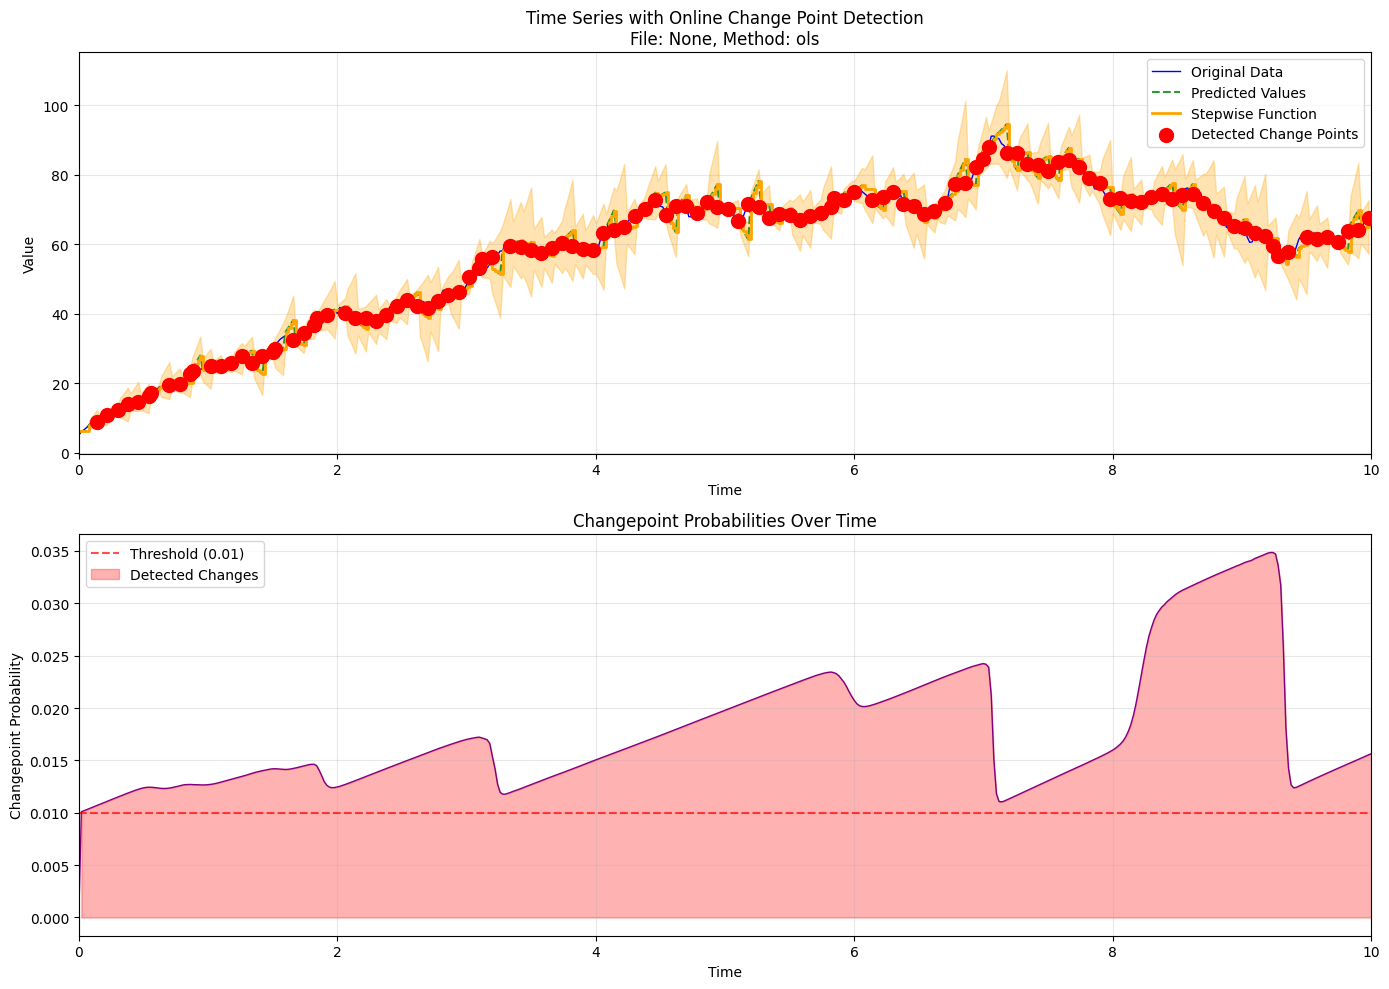


Prediction performance summary
Root mean square error (RMSE): 2.2757
Mean absolute error (MAE): 1.6881
Mean absolute percentage error (MAPE): 3.32%
Direction prediction accuracy: 51.9%
95% confidence interval coverage: 95.0%
Successfully predicted points: 500

✅ Prediction completed successfully!


In [4]:
# ==================== STEP 3: Run Prediction ====================
print(f"🔄 Running {method} predictor with window size {ws}...")
print(f"   This may take a few minutes...\n")

# Run the rolling predictor
result = rolling_predictor(
    times, 
    values, 
    **config['model_config'], 
    verbose=True,
    window_size=ws
)

print(f"\n{'='*60}")
print(f"✅ Prediction completed successfully!")
print(f"{'='*60}")


In [5]:
# ==================== STEP 4: Save Prediction Results ====================
# Construct output file path
output_filename = f'initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
file_path_prediction = f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/result_data/{output_filename}'

# Extract detailed results
detailed_results = result['detailed_results']

# Save only the compatible fields to CSV (excluding numpy arrays that don't fit)
# We'll save the time-series predictions
try:
    # Create a DataFrame with the main prediction results
    prediction_df = pd.DataFrame({
        'predicted_value': detailed_results.get('predicted_value', []),
        'actual_value': detailed_results.get('value', []),
        'prediction_error': detailed_results.get('prediction_errors', []),
        'stepwise_value': detailed_results.get('stepwise_value', []),
        'changepoint_prob': detailed_results.get('changepoint_probs', [])
    })
    
    # Save to CSV
    prediction_df.to_csv(file_path_prediction, index=False)
    print(f"💾 Results saved to:")
    print(f"   {output_filename}")
    print(f"   Saved {len(prediction_df)} prediction records")
except Exception as e:
    print(f"⚠️  Warning: Could not save detailed results to CSV: {e}")
    print(f"   Continuing with PMF generation...")

print(f"\n📈 Prediction Summary:")
print(f"   Number of predictions: {result['summary_metrics']['n_predictions']}")
print(f"   RMSE: {result['summary_metrics']['rmse']:.4f}")
print(f"   MAE: {result['summary_metrics']['mae']:.4f}")
print(f"   MAPE: {result['summary_metrics']['mape']:.2f}%")
print(f"   Direction accuracy: {result['summary_metrics']['direction_accuracy']:.1f}%")
print(f"   95% CI coverage: {result['summary_metrics']['confidence_coverage']:.1f}%")


⚠️  Warning: Could not save detailed results to CSV: array length 0 does not match index length 501
   Continuing with PMF generation...

📈 Prediction Summary:
   Number of predictions: 500
   RMSE: 2.2757
   MAE: 1.6881
   MAPE: 3.32%
   Direction accuracy: 51.9%
   95% CI coverage: 95.0%



📊 Generating PMF overlap plot...
   Comparing theoretical PMF with simulation histogram at t=7
   Step function shape: (501,)
   Time interval shape: (501,)
   Service rate (mu): 10
✓ Plotted PMF for window size 4
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.019433]
  PMF length: 601, Plotted length: 600


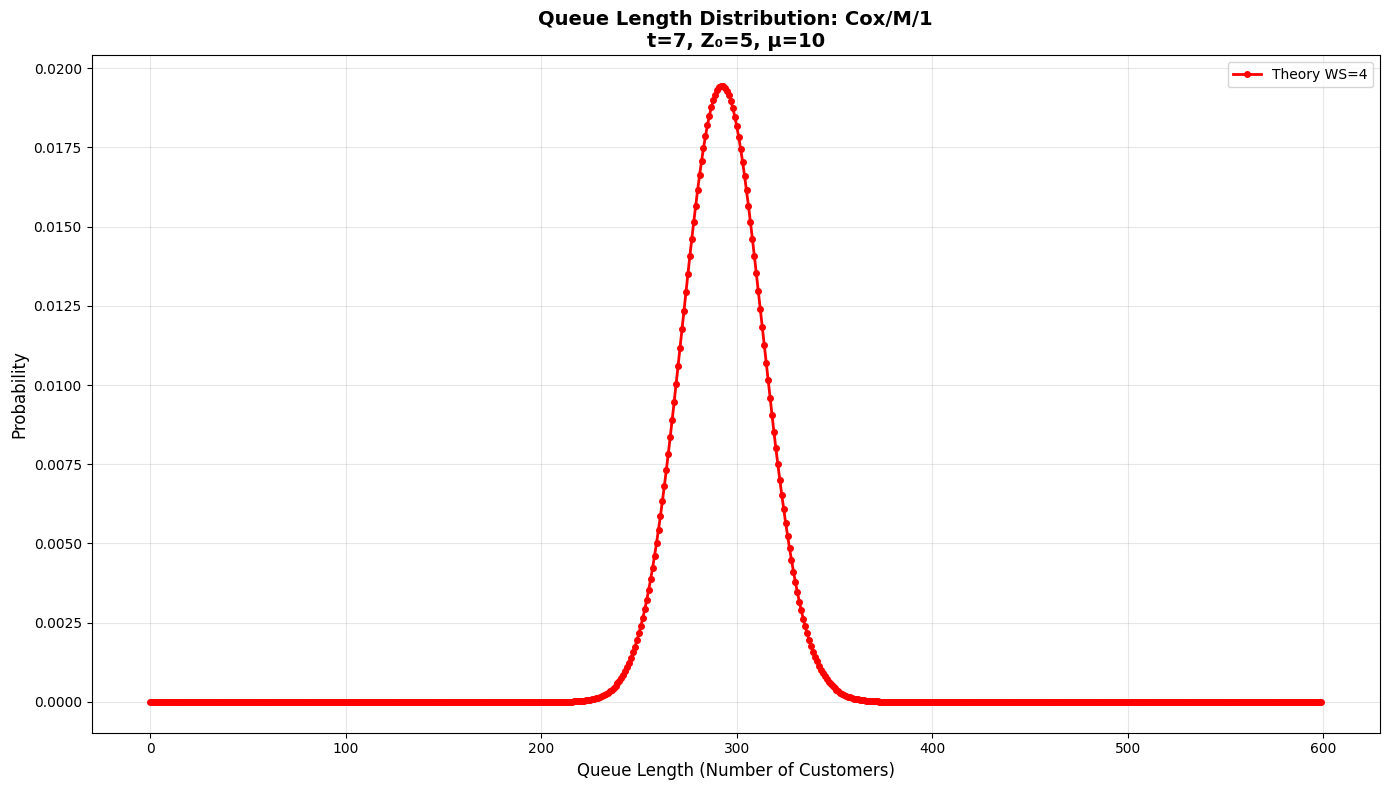

UnboundLocalError: local variable 'bins' referenced before assignment

In [6]:
# ==================== STEP 5: Generate PMF Overlap Plot ====================
print(f"\n📊 Generating PMF overlap plot...")
print(f"   Comparing theoretical PMF with simulation histogram at t={t}")

# Construct PMF save path
pmf_folder = f'initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}'
file_path_pmf = f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/pmf_data/M=500/{pmf_folder}/'

# Extract predicted step functions from the predictor results
# These are piecewise constant arrival rate estimates from change point detection
Z_piece = result['detailed_results']['predicted_step_function']
dt_piece = result['detailed_results']['predicted_step_function_time_interval']

print(f"   Step function shape: {Z_piece.shape}")
print(f"   Time interval shape: {dt_piece.shape}")

# Determine service rate (mu) based on initial queue length
# Different scenarios use different service rates
mu = 10 if z_initial == 5 else 100 if z_initial == 80 else 100
print(f"   Service rate (mu): {mu}")

# Generate PMF overlap plot
# This compares the theoretical transient PMF (calculated from predicted step function)
# with the actual simulation histogram
plot_pmf_overlap(
    window_sizes=[ws],  # Can compare multiple window sizes
    t=t,  # Time point for PMF evaluation
    file_path=file_path_prediction,
    save_path=file_path_pmf,
    Z_piece=Z_piece,  # Predicted piecewise constant arrival rates
    dt_piece=dt_piece,  # Time intervals for each piece
    mu=mu,  # Service rate
    m=1,  # Number of servers (M/M/1 queue)
    z_initial=z_initial,
    hist_data_path='/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/Simulation_histograms',
    N=600,  # Maximum number of states in the PMF
    show_histogram=True  # Overlay simulation histogram
)

print(f"\n✅ All tasks completed successfully!")
print(f"   Prediction results saved to: data_integrated/result_data/")
print(f"   PMF plots saved to: data_integrated/pmf_data/M=500/")
print(f"\n💡 Tip: To run a different experiment, change 'scenario' or 'method' in Cell 2")



📊 Generating PMF overlap plot...
   Comparing theoretical PMF with simulation histogram at t=7
   Step function shape: (501,)
   Time interval shape: (501,)
   Service rate (mu): 10
✓ Plotted PMF for window size 4
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.019433]
  PMF length: 601, Plotted length: 600


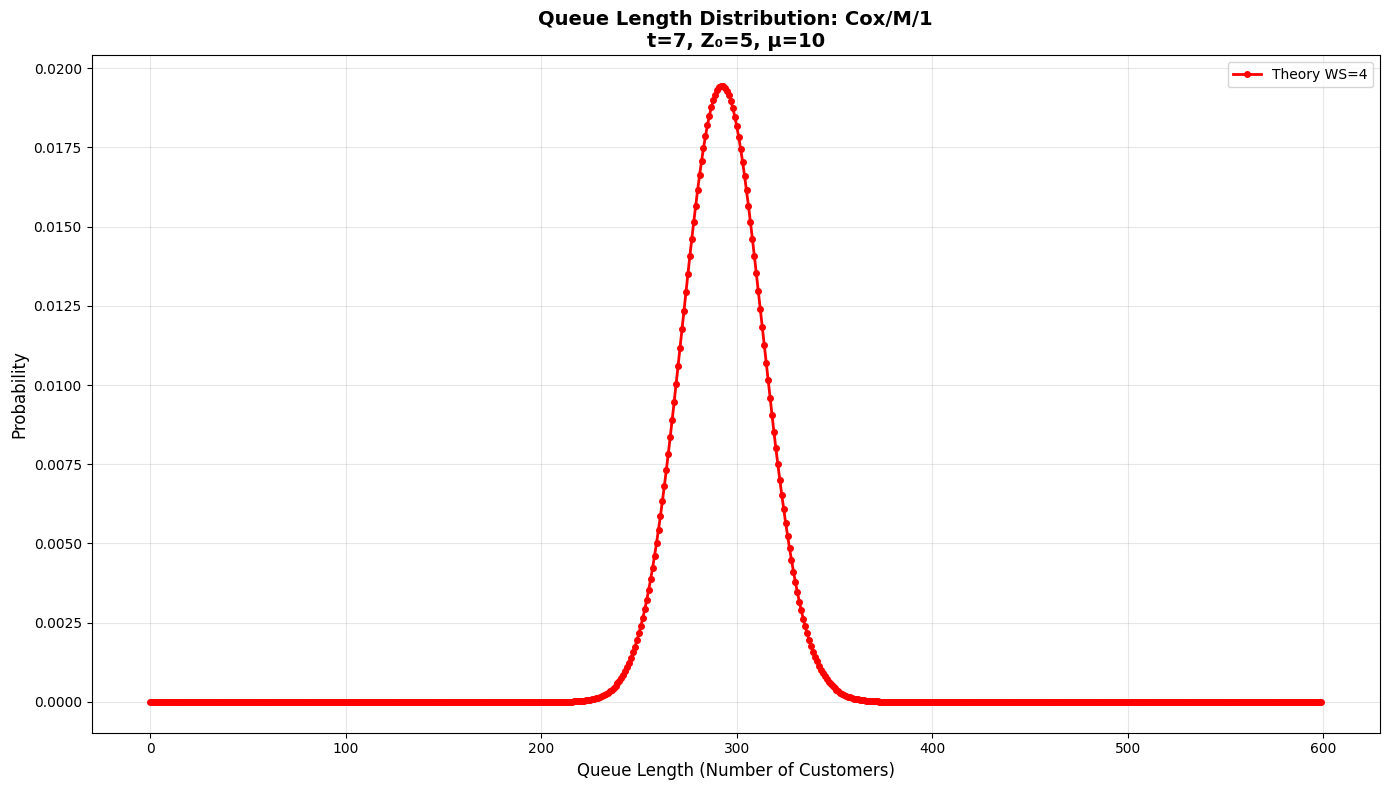

UnboundLocalError: local variable 'bins' referenced before assignment

In [7]:
# ==================== STEP 5: Generate PMF Overlap Plot ====================
print(f"\n📊 Generating PMF overlap plot...")
print(f"   Comparing theoretical PMF with simulation histogram at t={t}")

# Construct PMF save path
pmf_folder = f'initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}'
file_path_pmf = f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/pmf_data/M=500/{pmf_folder}/'

# Extract predicted step functions from the predictor results
# These are piecewise constant arrival rate estimates from change point detection
Z_piece = result['detailed_results']['predicted_step_function']
dt_piece = result['detailed_results']['predicted_step_function_time_interval']

print(f"   Step function shape: {Z_piece.shape}")
print(f"   Time interval shape: {dt_piece.shape}")

# Determine service rate (mu) based on initial queue length
# Different scenarios use different service rates
mu = 10 if z_initial == 5 else 100 if z_initial == 80 else 100
print(f"   Service rate (mu): {mu}")

# Generate PMF overlap plot
# This compares the theoretical transient PMF (calculated from predicted step function)
# with the actual simulation histogram
plot_pmf_overlap(
    window_sizes=[ws],  # Can compare multiple window sizes
    t=t,  # Time point for PMF evaluation
    file_path=file_path_prediction,
    save_path=file_path_pmf,
    Z_piece=Z_piece,  # Predicted piecewise constant arrival rates
    dt_piece=dt_piece,  # Time intervals for each piece
    mu=mu,  # Service rate
    m=1,  # Number of servers (M/M/1 queue)
    z_initial=z_initial,
    hist_data_path='/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/Simulation_histograms',
    N=600,  # Maximum number of states in the PMF
    show_histogram=True  # Overlay simulation histogram
)

print(f"\n✅ All tasks completed successfully!")
print(f"   Prediction results saved to: data_integrated/result_data/")
print(f"   PMF plots saved to: data_integrated/pmf_data/M=500/")
print(f"\n💡 Tip: To run a different experiment, change 'scenario' or 'method' in Cell 2")


---
## Optional: Inspect Results

The cells below are optional and can be used to inspect and visualize the results in more detail.


In [ ]:
if __name__ == "__main__":
    from config.transient.cpd_bayesian import config
    from utils.utils import rolling_predictor, plot_pmf_overlap
    from config.transient.z5t1 import config
    import pandas as pd
 
    values = pd.read_csv(f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, **config, verbose=True,method=config['method'],window_size=config['ws'])
    file_path_prediction = f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{config['z_initial']}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=config['z_initial'],
        hist_data_path='/Users/qianxinhui/Desktop/NU-Research/cox/change-point-detection/data_integrated/Simulation_histograms',
        N=100, # max number of states
        show_histogram=True
    )

SyntaxError: f-string: unmatched '[' (1208916324.py, line 17)

In [ ]:
if __name__ == "__main__":
    #Parameters  for prediction
    z_initial=5
    min_history_length=10
    ws=5
    method='cpd'
    t=1
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=100, # max number of states
        show_histogram=True
    )

FileNotFoundError: [Errno 2] No such file or directory: '/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_5_samples_500.csv'

kalman_Predictor
Rolling prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=10.33, Actual=10.53, Error=0.19
Time 0.220: Predicted=10.77, Actual=11.00, Error=0.22
Time 0.240: Predicted=11.21, Actual=11.33, Error=0.12
Time 0.260: Predicted=11.63, Actual=12.18, Error=0.55
Time 0.280: Predicted=12.10, Actual=12.61, Error=0.51
Successfully predicted: 491 points


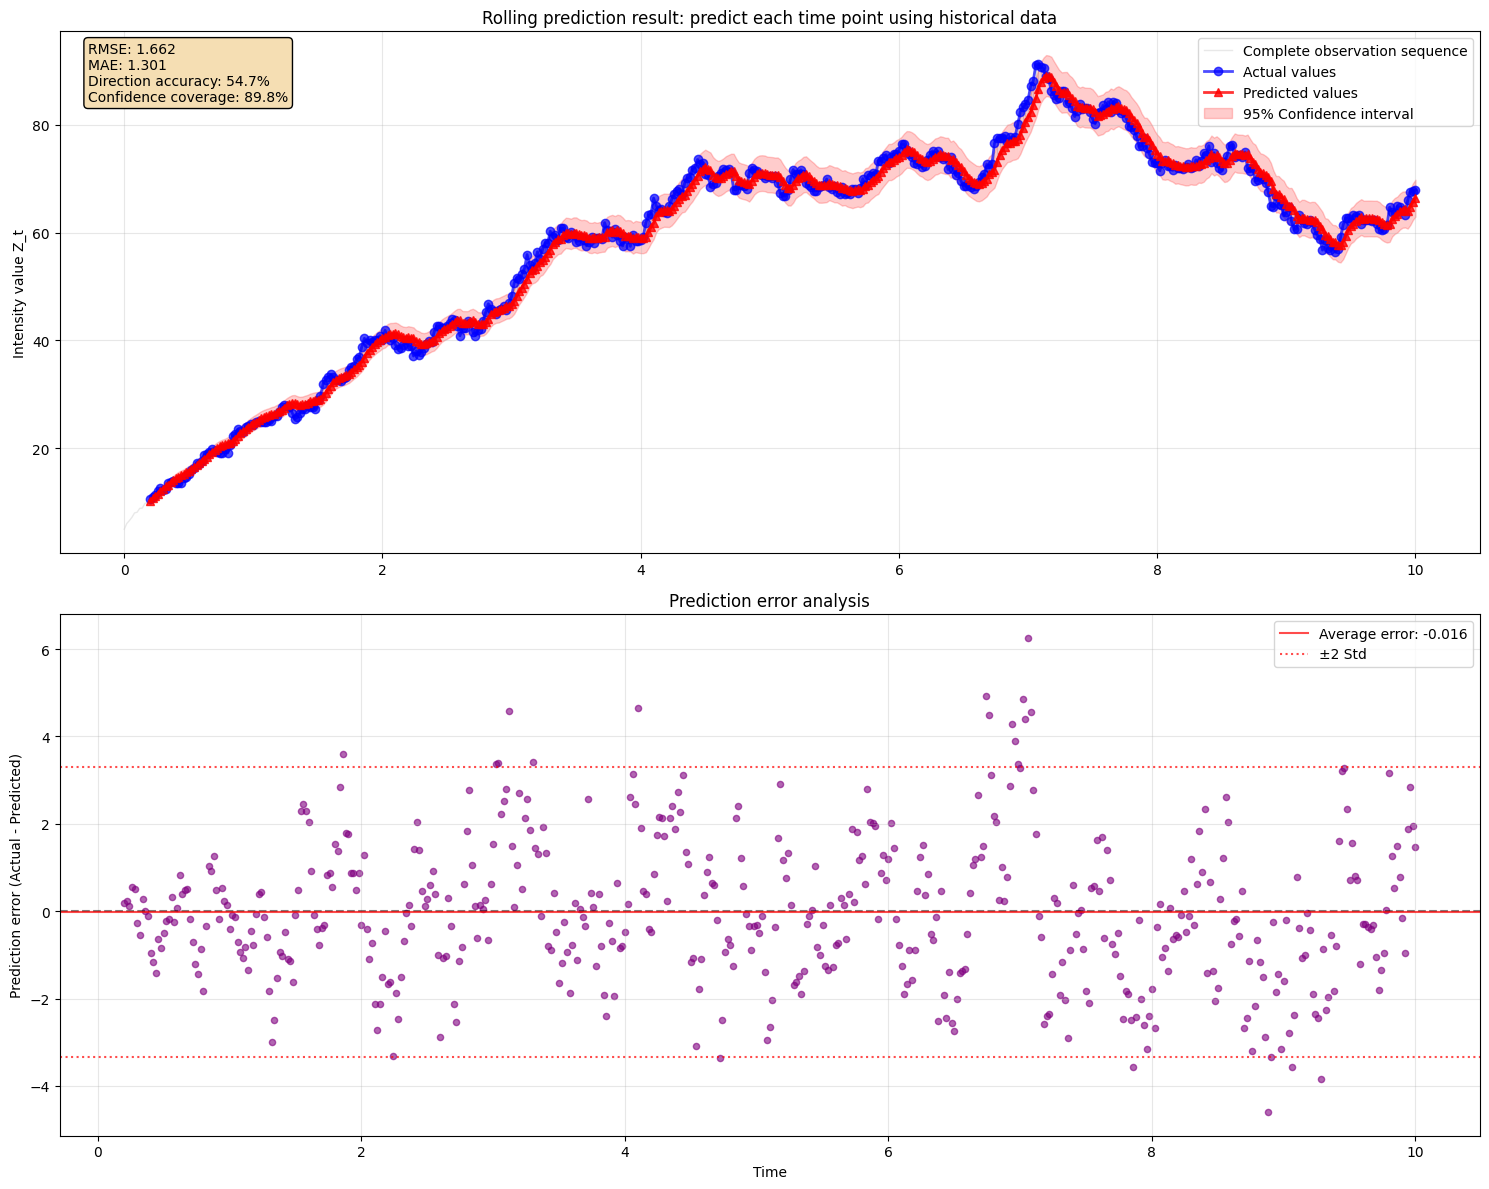


Prediction performance summary
Root mean square error (RMSE): 1.6623
Mean absolute error (MAE): 1.3014
Mean absolute percentage error (MAPE): 2.41%
Direction prediction accuracy: 54.7%
95% confidence interval coverage: 89.8%
Successfully predicted points: 491

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z05_serv10_t1.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.096277]
  Bins range: [0.0, 37.0]
length of bins: 38, length of counts: 37
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.093973]
  PMF length: 351, Plotted length: 350


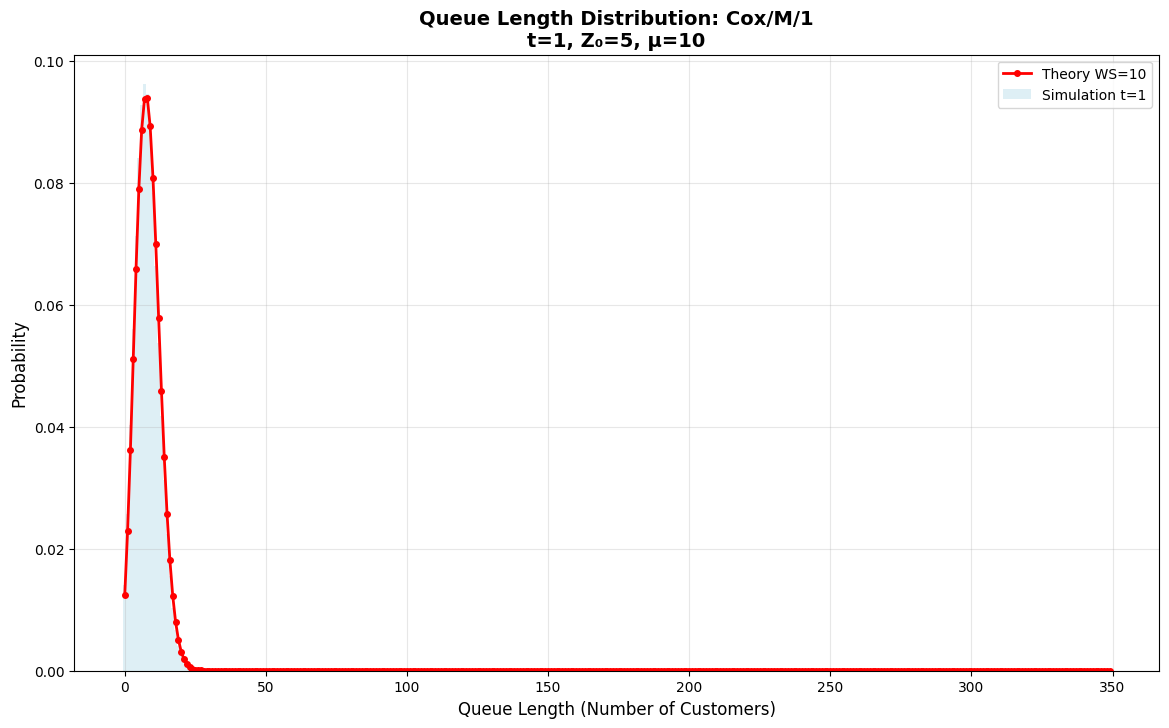

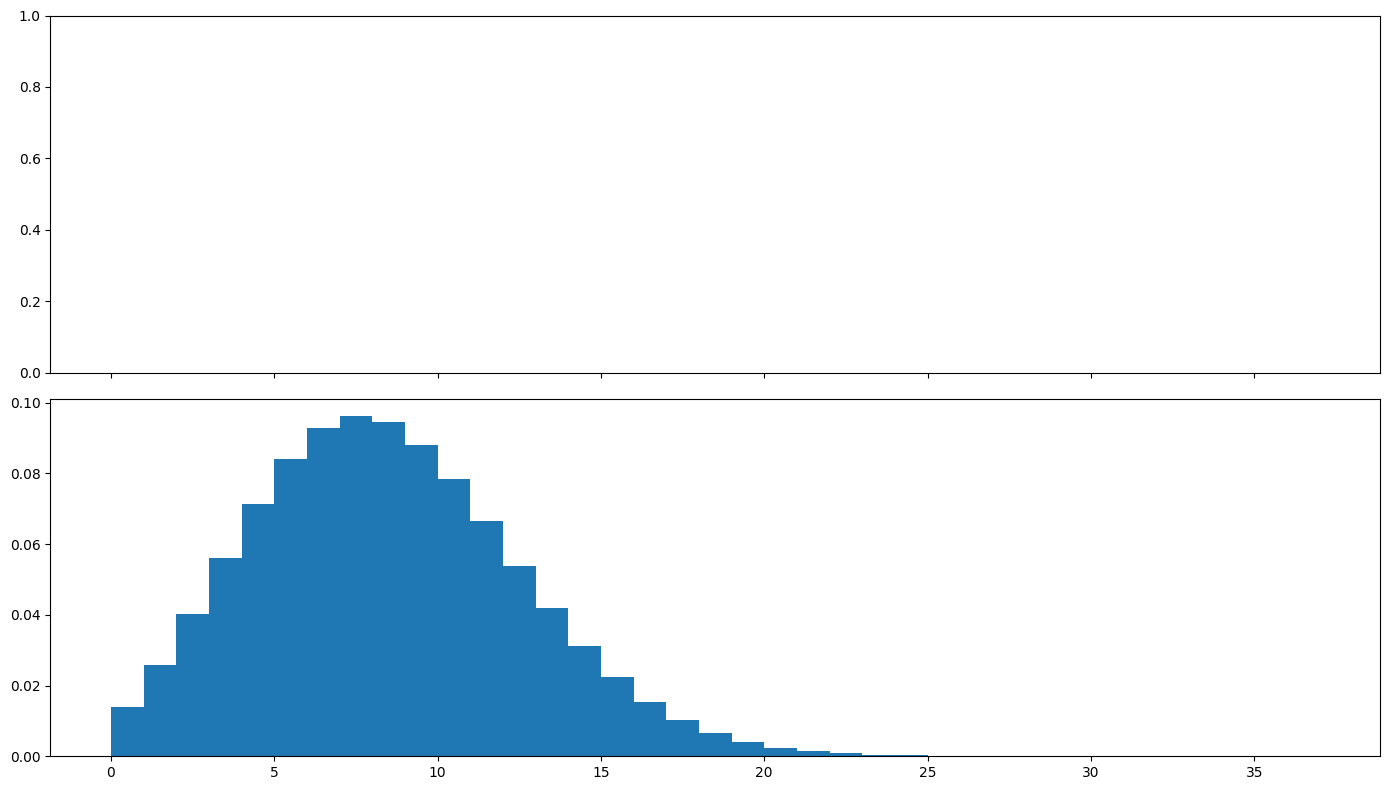

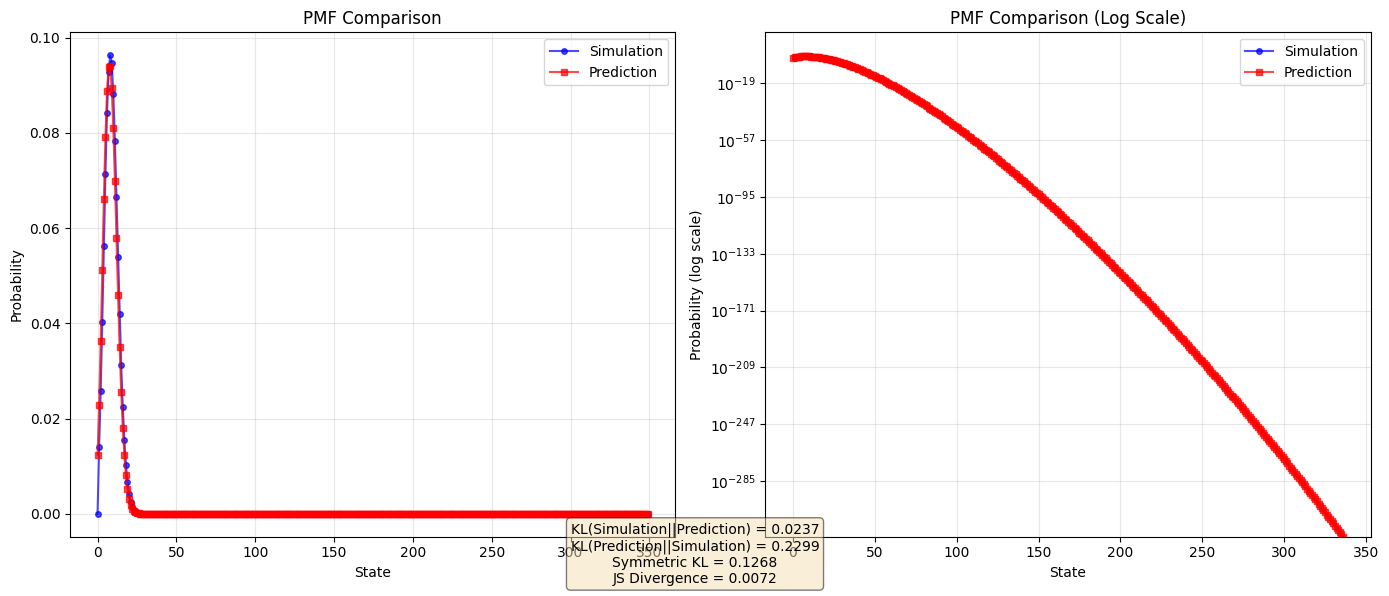

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_5_samples_500_predicted_kalman_pmf_min_hist_length_10/pmf_overlap_t1.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    min_history_length=10
    method='kalman'
    t=1
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print(f"{method}_Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=t,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=350, # max number of states
        show_histogram=True
    )

# Z0=5,t=5

In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    min_history_length=10
    method='cpd_bayesian'
    t=5
    window_size=15
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print(f"{method}_Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=window_size)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=t,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )

KeyboardInterrupt: 

cpd Predictor


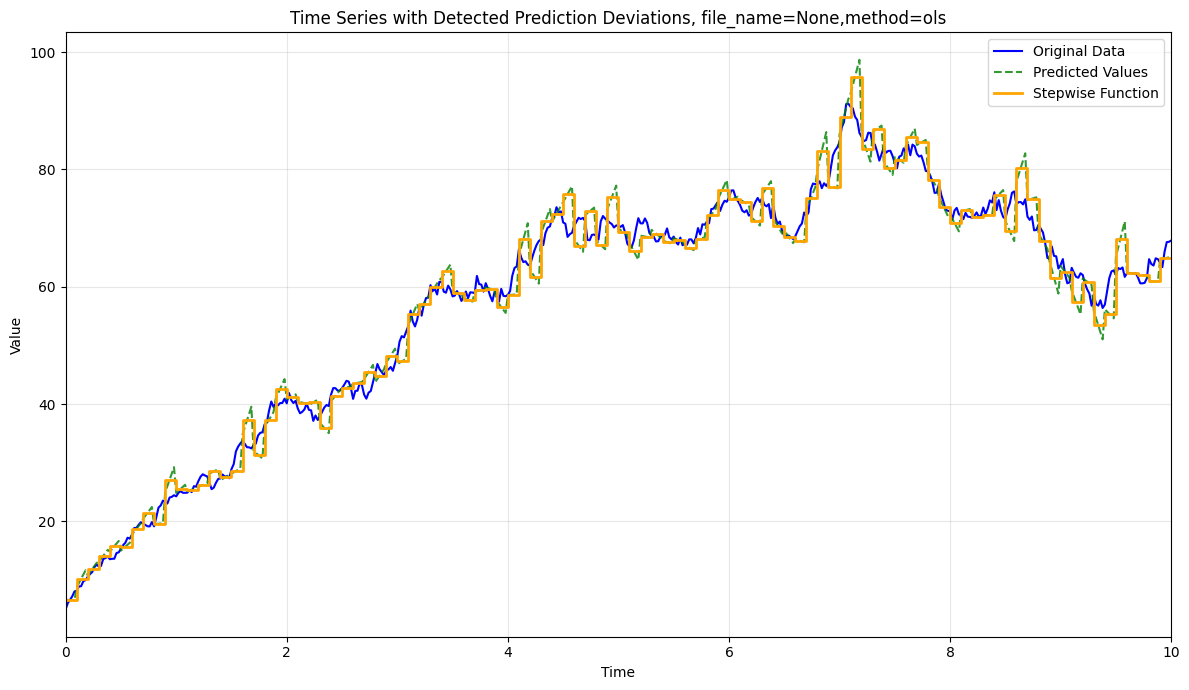


Prediction performance summary
Root mean square error (RMSE): 2.9250
Mean absolute error (MAE): 2.1618
Mean absolute percentage error (MAPE): 4.22%
Direction prediction accuracy: 51.7%
95% confidence interval coverage: 99.8%
Successfully predicted points: 500

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
(501,) (501,)
✓ Loaded histogram: for_histogram_CoxM1_Z05_serv10_t5.pickle
  Total count: 1.444444444444439
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.025004]
  Bins range: [0, 260]
length of bins: 341, length of counts: 340
✓ Plotted PMF for window size 5
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.024821]
  PMF length: 271, Plotted length: 270


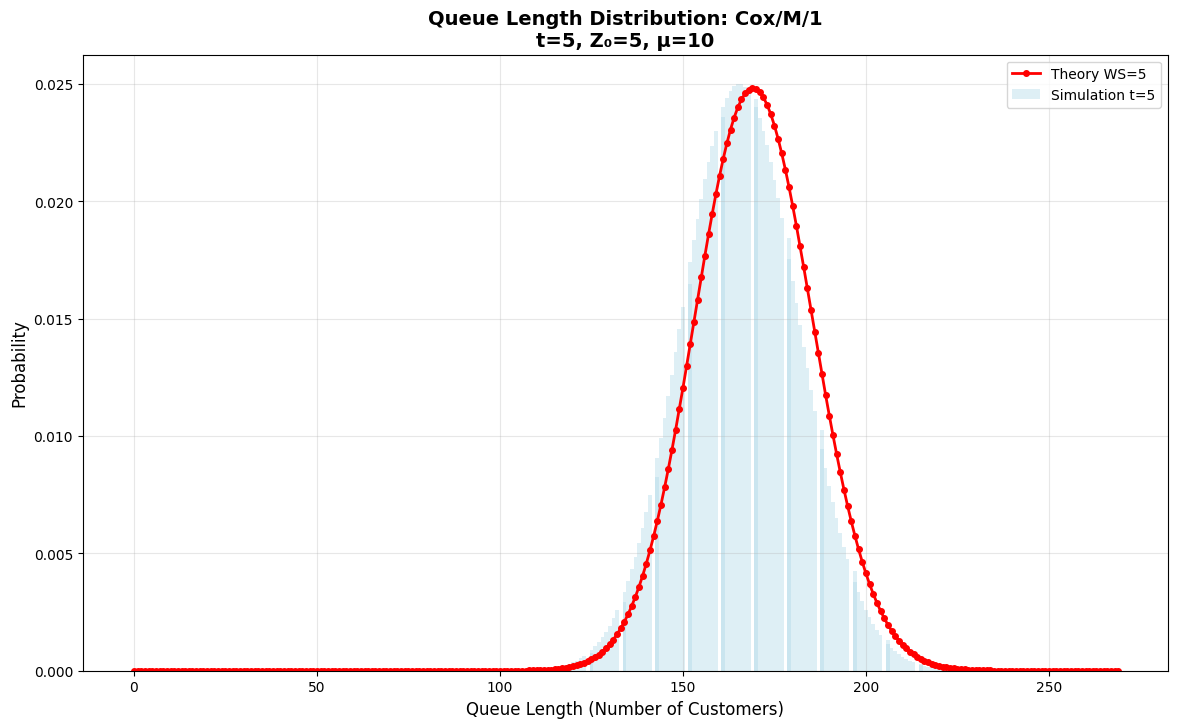

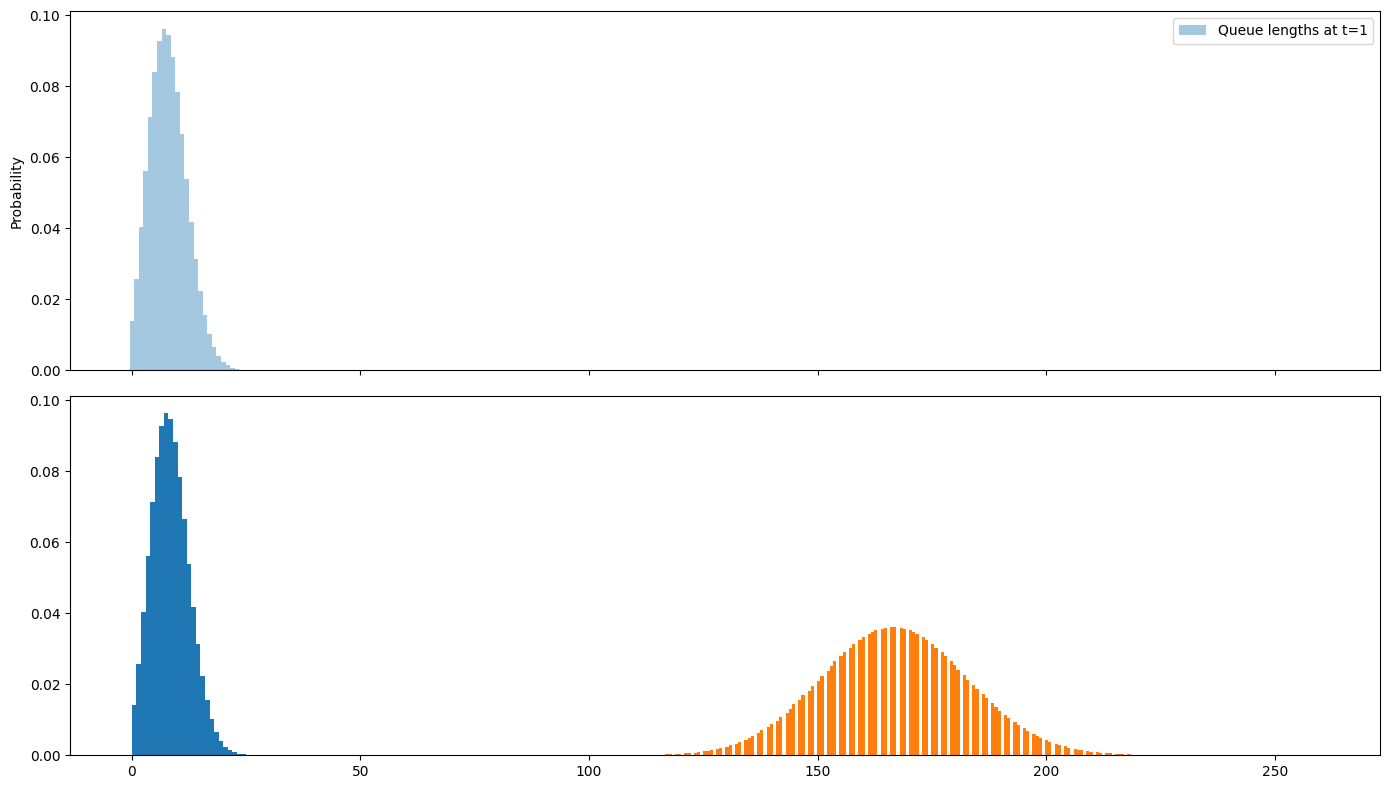

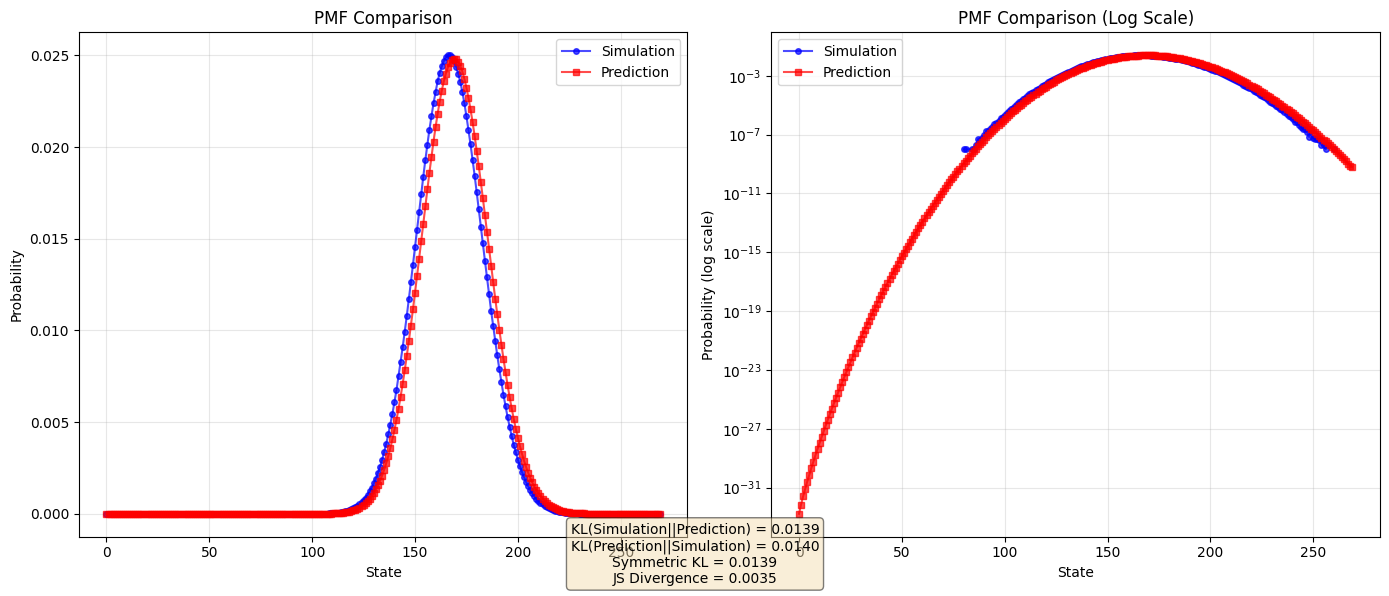

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_5_samples_500_predicted_cpd_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    #Parameters  for prediction
    z_initial=5
    min_history_length=10
    ws=5
    method='cpd'
    t=5
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )

kalman_Predictor
Rolling prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=10.33, Actual=10.53, Error=0.19
Time 0.220: Predicted=10.77, Actual=11.00, Error=0.22
Time 0.240: Predicted=11.21, Actual=11.33, Error=0.12
Time 0.260: Predicted=11.63, Actual=12.18, Error=0.55
Time 0.280: Predicted=12.10, Actual=12.61, Error=0.51
Successfully predicted: 491 points


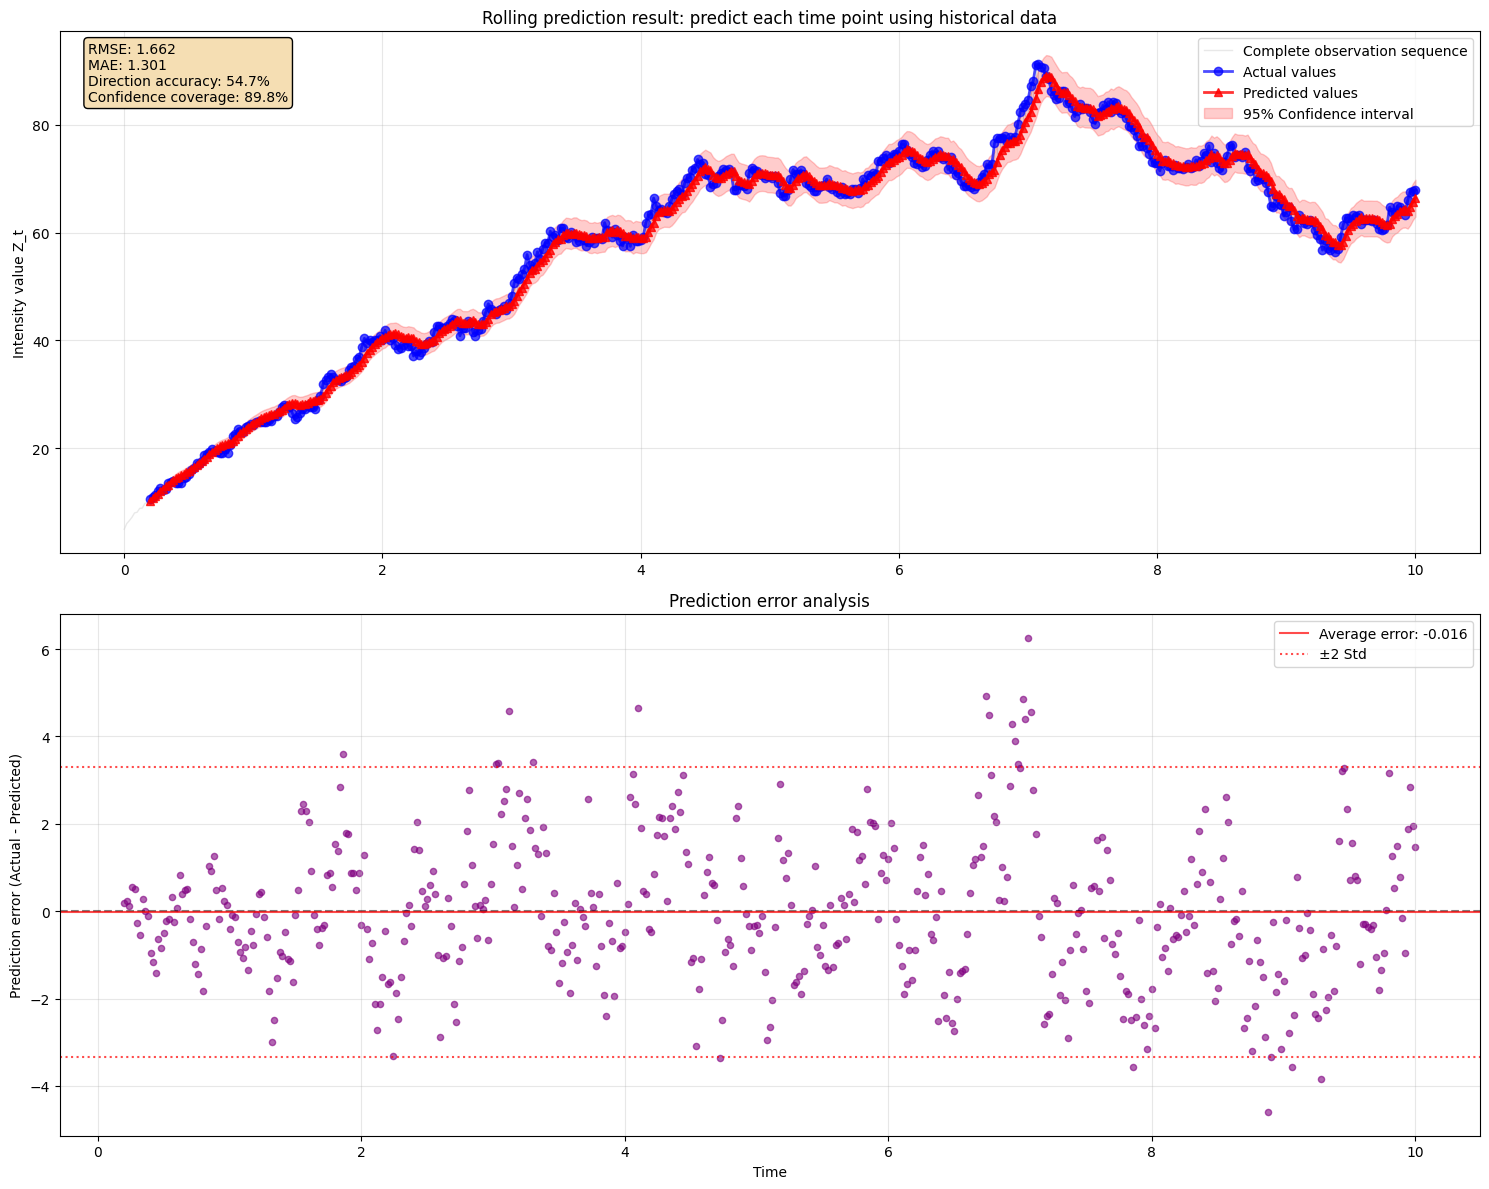


Prediction performance summary
Root mean square error (RMSE): 1.6623
Mean absolute error (MAE): 1.3014
Mean absolute percentage error (MAPE): 2.41%
Direction prediction accuracy: 54.7%
95% confidence interval coverage: 89.8%
Successfully predicted points: 491

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z05_serv10_t5.pickle
  Total count: 1.444444444444439
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.025004]
  Bins range: [0, 260]
length of bins: 341, length of counts: 340
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.024952]
  PMF length: 271, Plotted length: 270


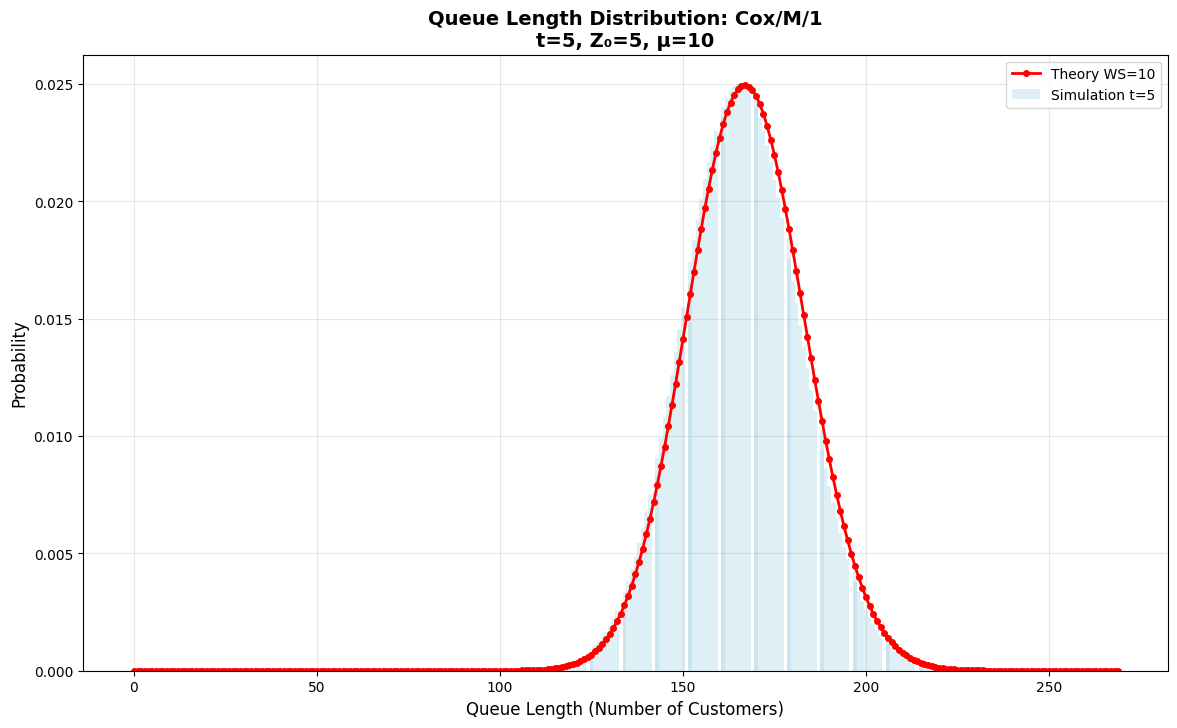

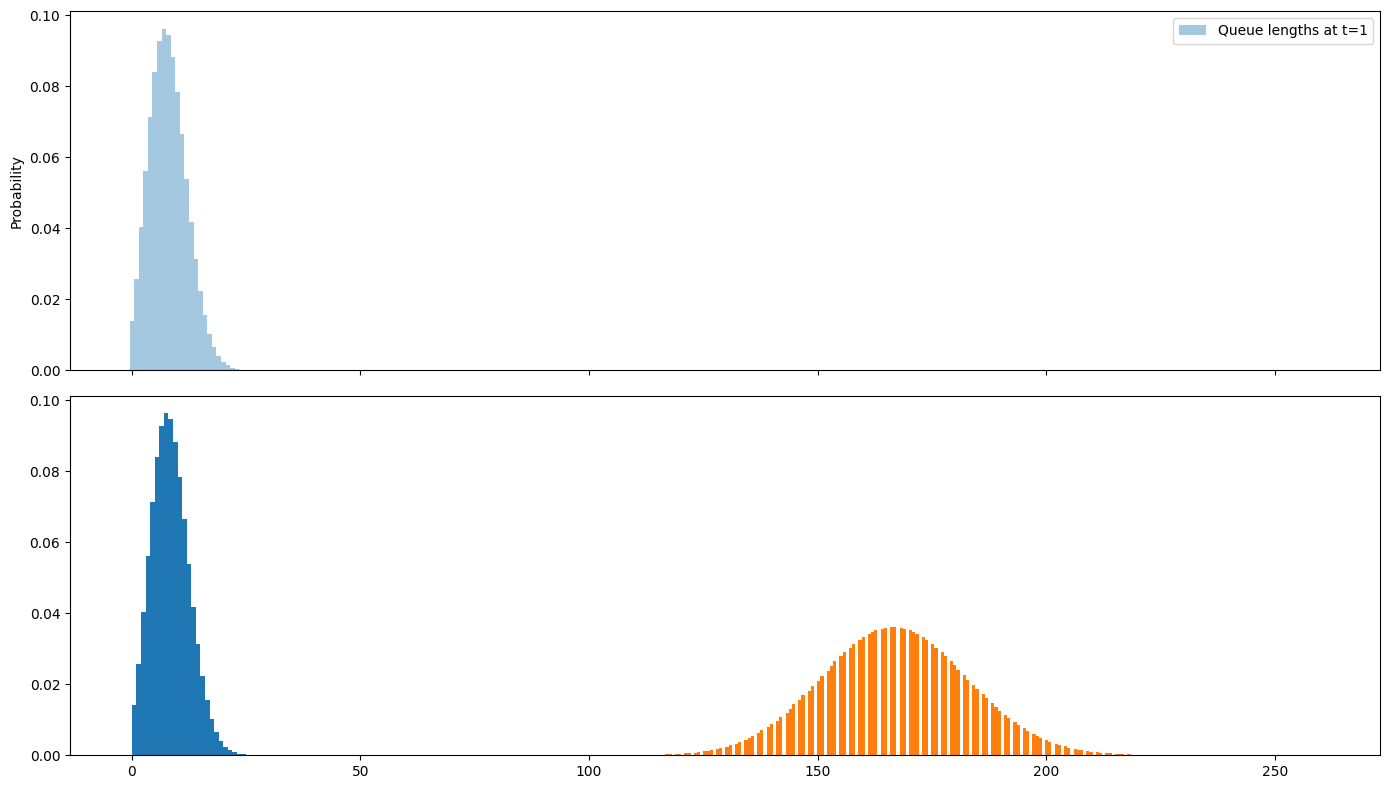

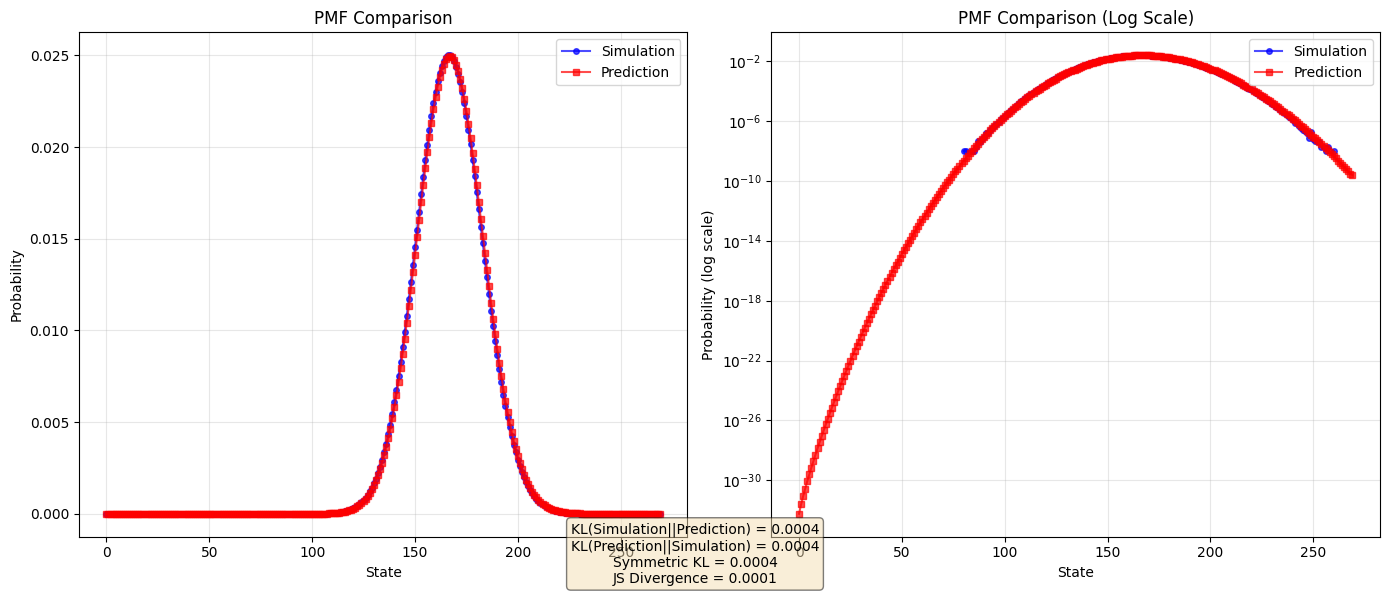

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_5_samples_500_predicted_kalman_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    min_history_length=10
    method='kalman'
    t=5
    
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print(f"{method}_Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=t,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )

# Z0=80,t=5

cpd_bayesian_Predictor
Running online BOCPD...
Processed 1/501 points, current CP prob: 0.0500
Processed 51/501 points, current CP prob: 0.0500
Processed 101/501 points, current CP prob: 0.0500
Processed 151/501 points, current CP prob: 0.0500
Processed 201/501 points, current CP prob: 0.0500
Processed 251/501 points, current CP prob: 0.0500
Processed 301/501 points, current CP prob: 0.0500
Processed 351/501 points, current CP prob: 0.0500
Processed 401/501 points, current CP prob: 0.0500
Processed 451/501 points, current CP prob: 0.0500
Processed 501/501 points, current CP prob: 0.0500
Running windowed prediction...
Step 30: Max CP probability in window = 0.0500
Change point detected at index 15 with probability 0.0500
Step 45: Max CP probability in window = 0.0500
Change point detected at index 41 with probability 0.0500
Step 60: Max CP probability in window = 0.0500
Change point detected at index 47 with probability 0.0500
Step 75: Max CP probability in window = 0.0500
Change point 

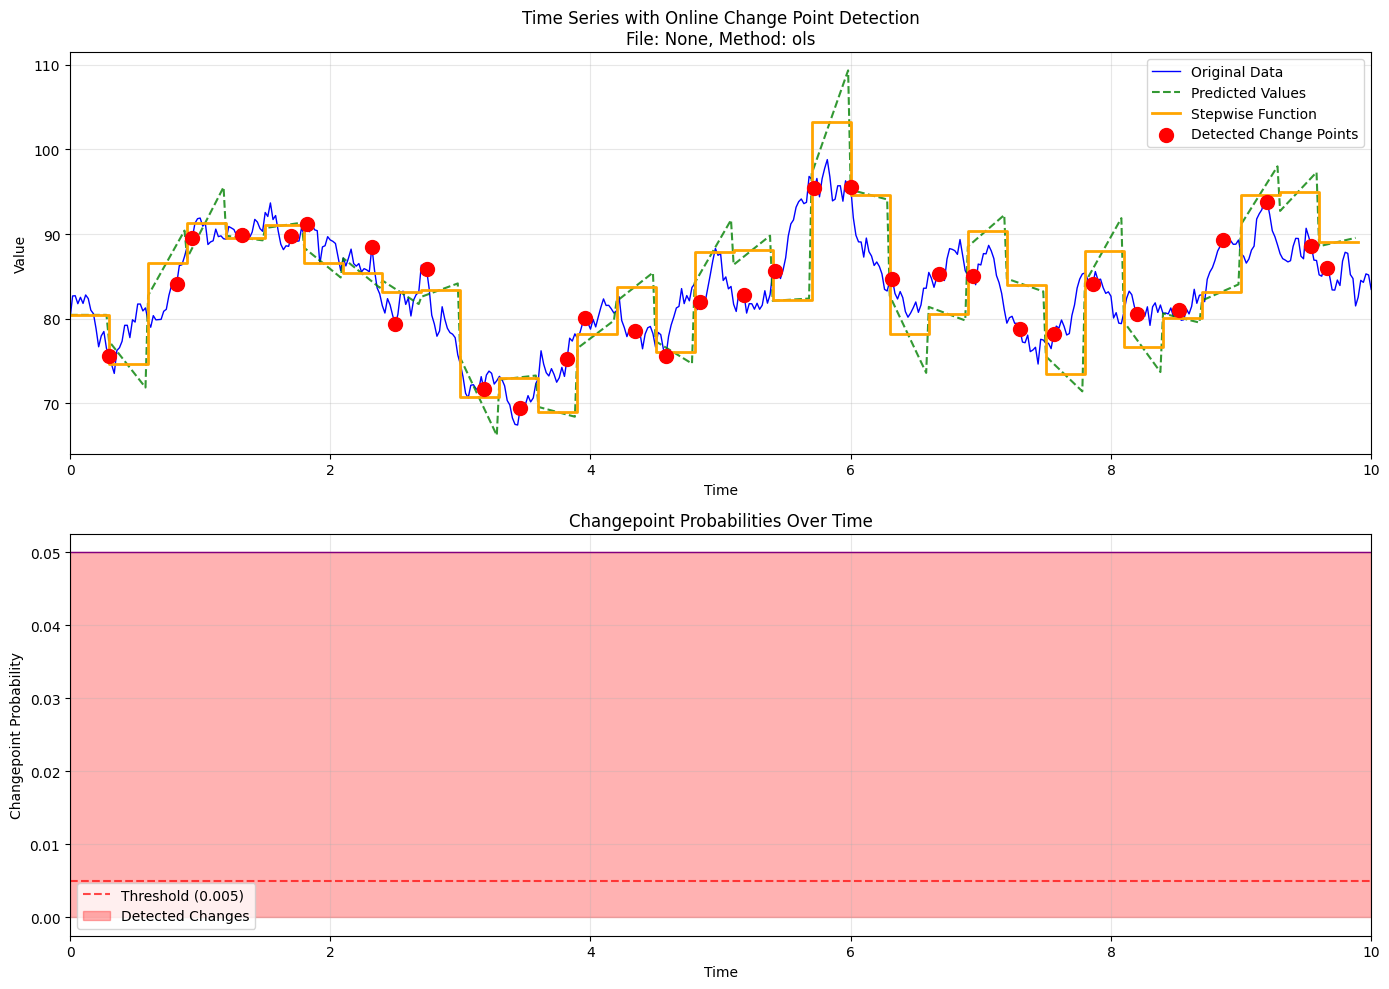


Prediction performance summary
Root mean square error (RMSE): 5.0997
Mean absolute error (MAE): 4.1689
Mean absolute percentage error (MAPE): 5.00%
Direction prediction accuracy: 49.8%
95% confidence interval coverage: 95.0%
Successfully predicted points: 495

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t5.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.164993]
  Bins range: [0.0, 98.0]
length of bins: 99, length of counts: 98
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.155770]
  PMF length: 101, Plotted length: 100


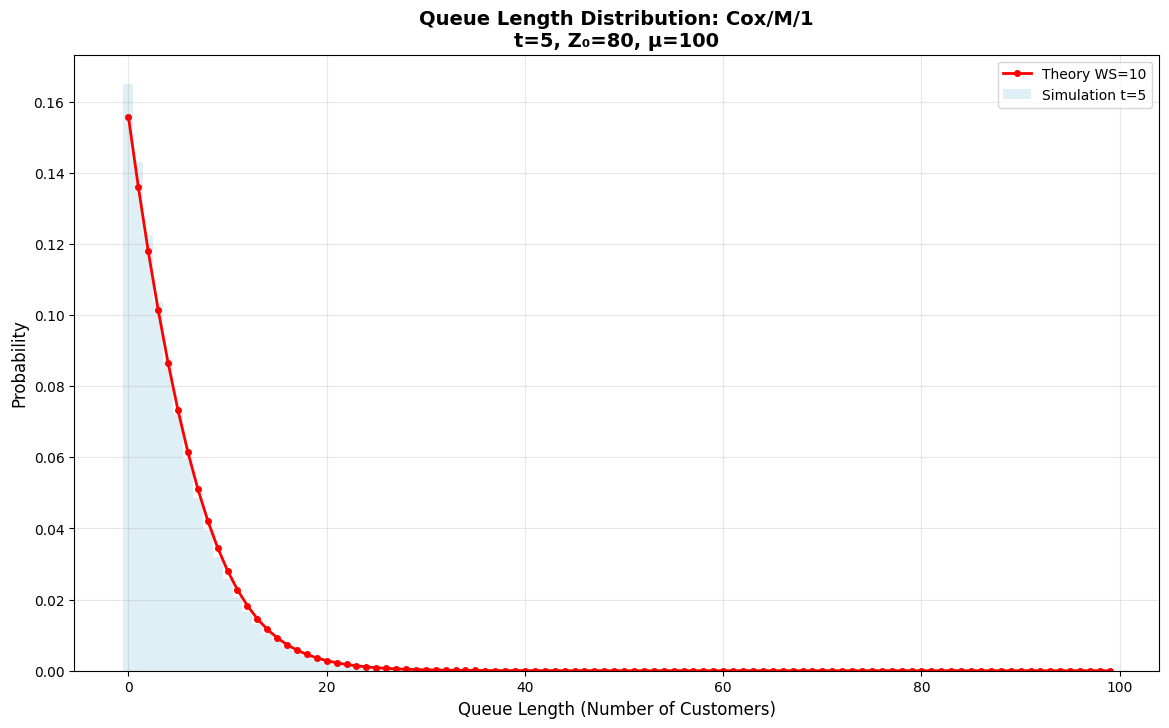

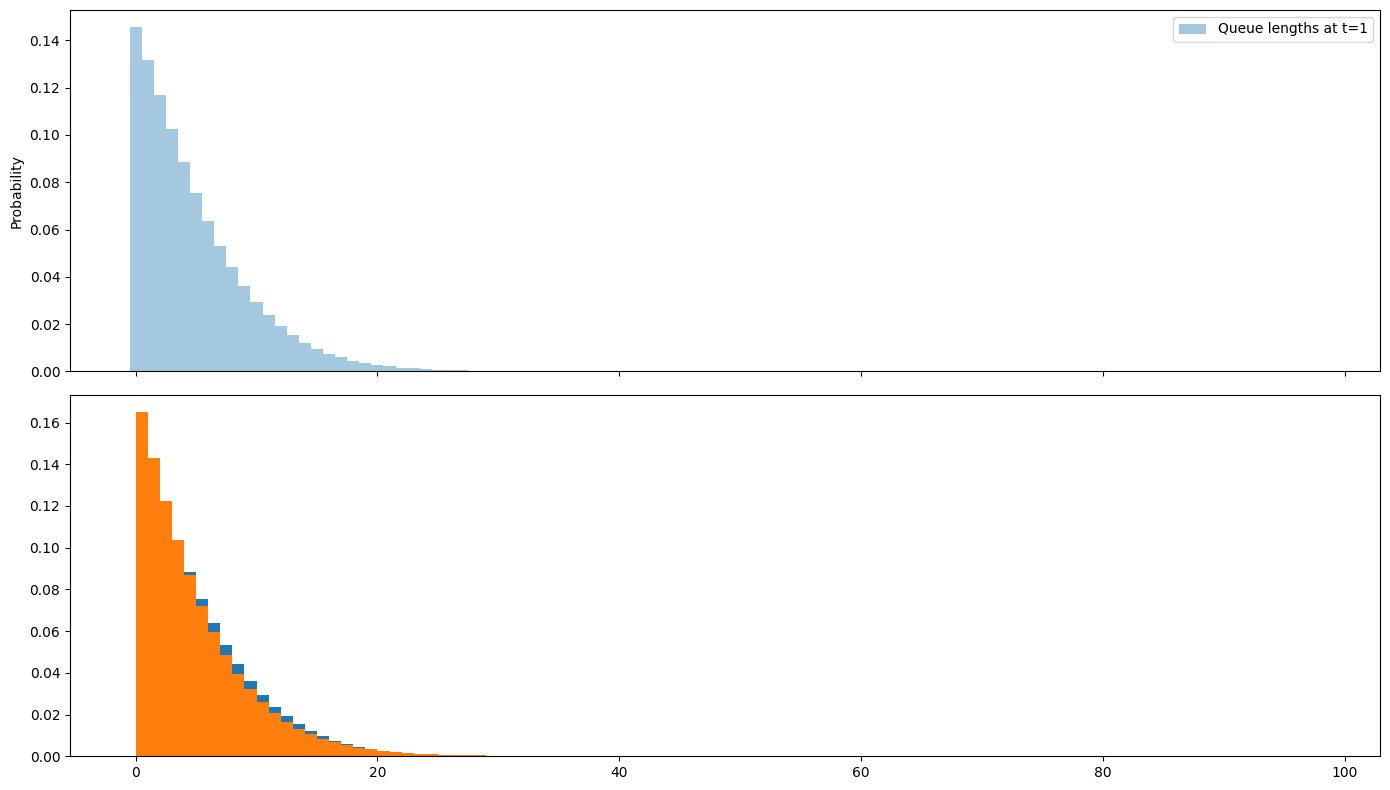

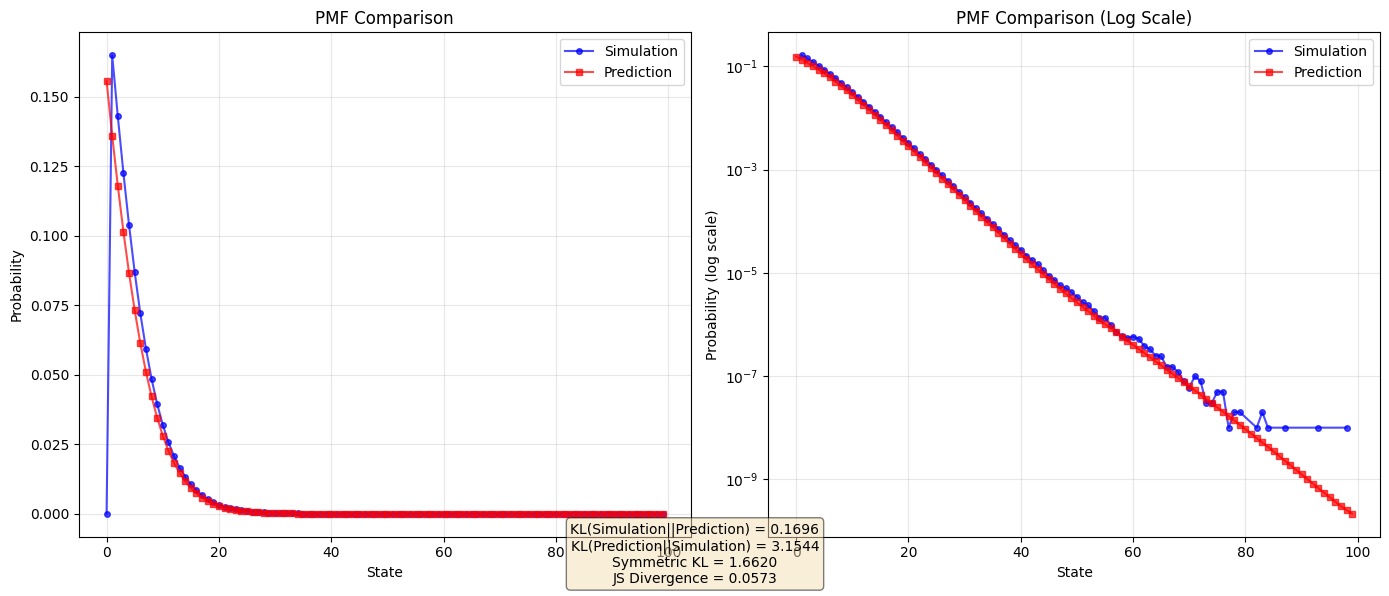

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_cpd_bayesian_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=80
    min_history_length=10
    ws=15
    method='cpd_bayesian'
    t=5
    
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print(f"{method}_Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=t,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=100, # max number of states
        show_histogram=True
    )

kalman_Predictor
Rolling prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=81.43, Actual=78.82, Error=-2.61
Time 0.220: Predicted=80.47, Actual=76.67, Error=-3.81
Time 0.240: Predicted=79.00, Actual=77.95, Error=-1.04
Time 0.260: Predicted=78.60, Actual=78.47, Error=-0.13
Time 0.280: Predicted=78.59, Actual=76.48, Error=-2.11
Successfully predicted: 491 points


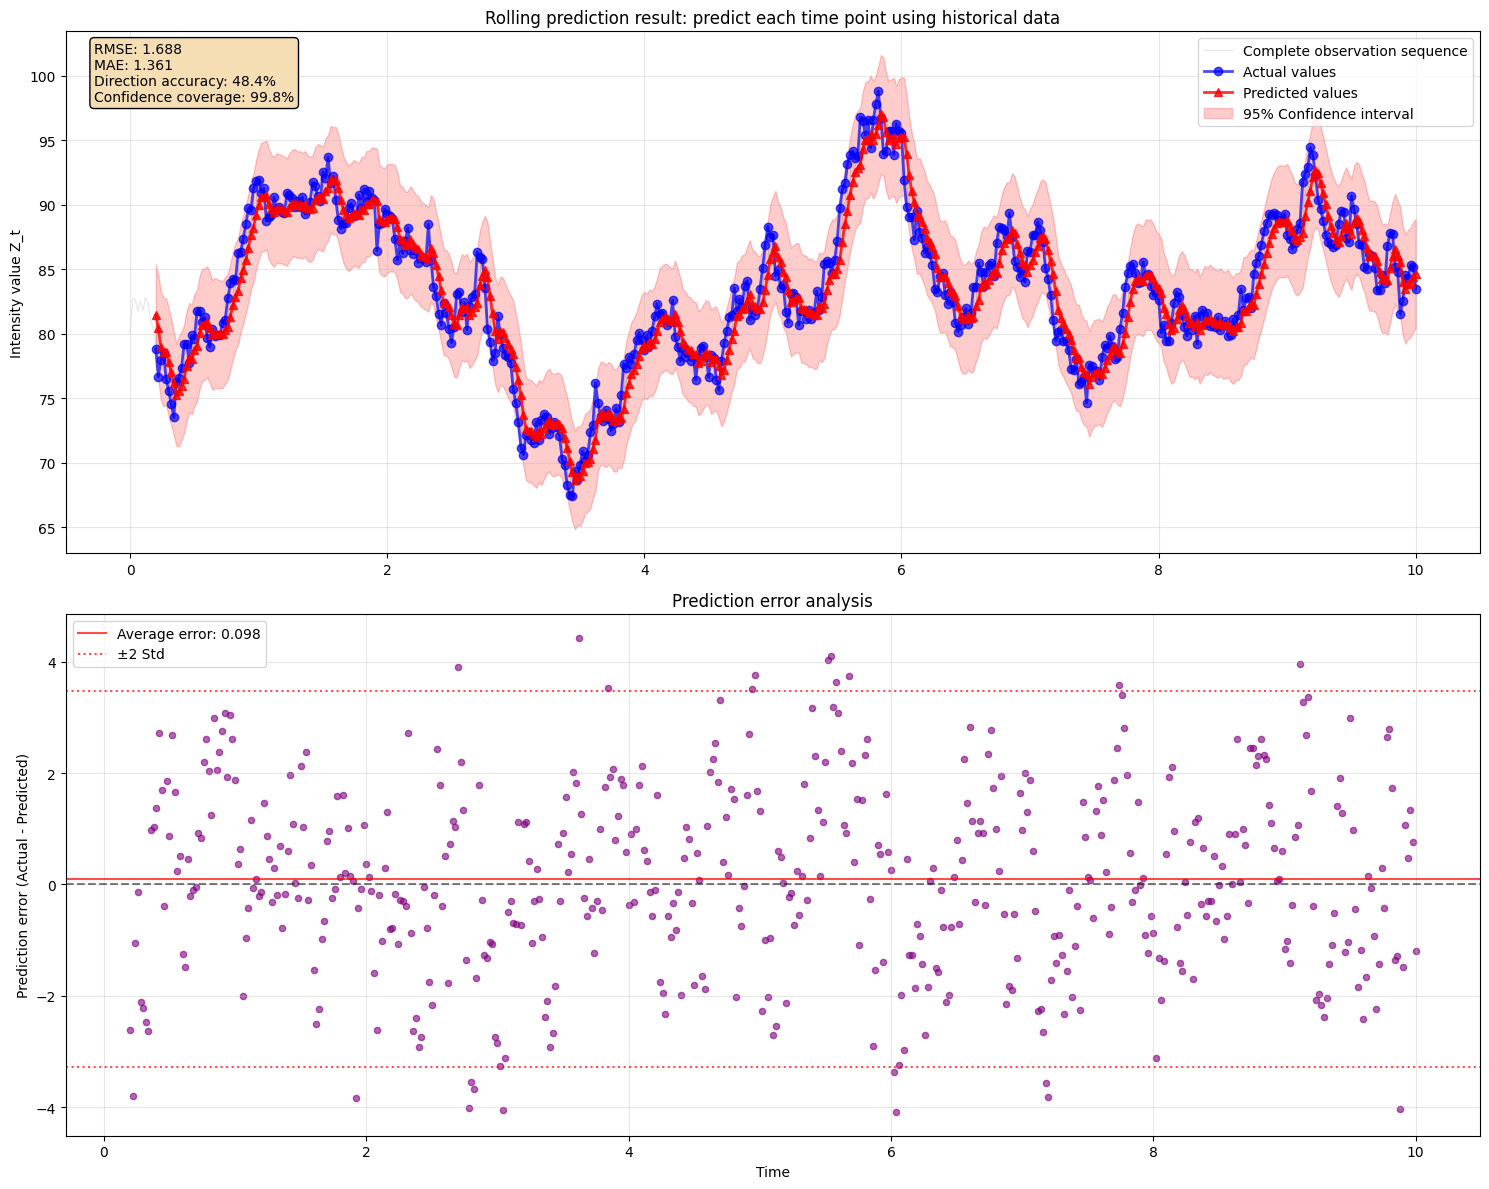


Prediction performance summary
Root mean square error (RMSE): 1.6882
Mean absolute error (MAE): 1.3606
Mean absolute percentage error (MAPE): 1.63%
Direction prediction accuracy: 48.4%
95% confidence interval coverage: 99.8%
Successfully predicted points: 491

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t5.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.164993]
  Bins range: [0.0, 98.0]
length of bins: 99, length of counts: 98
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.173261]
  PMF length: 101, Plotted length: 100


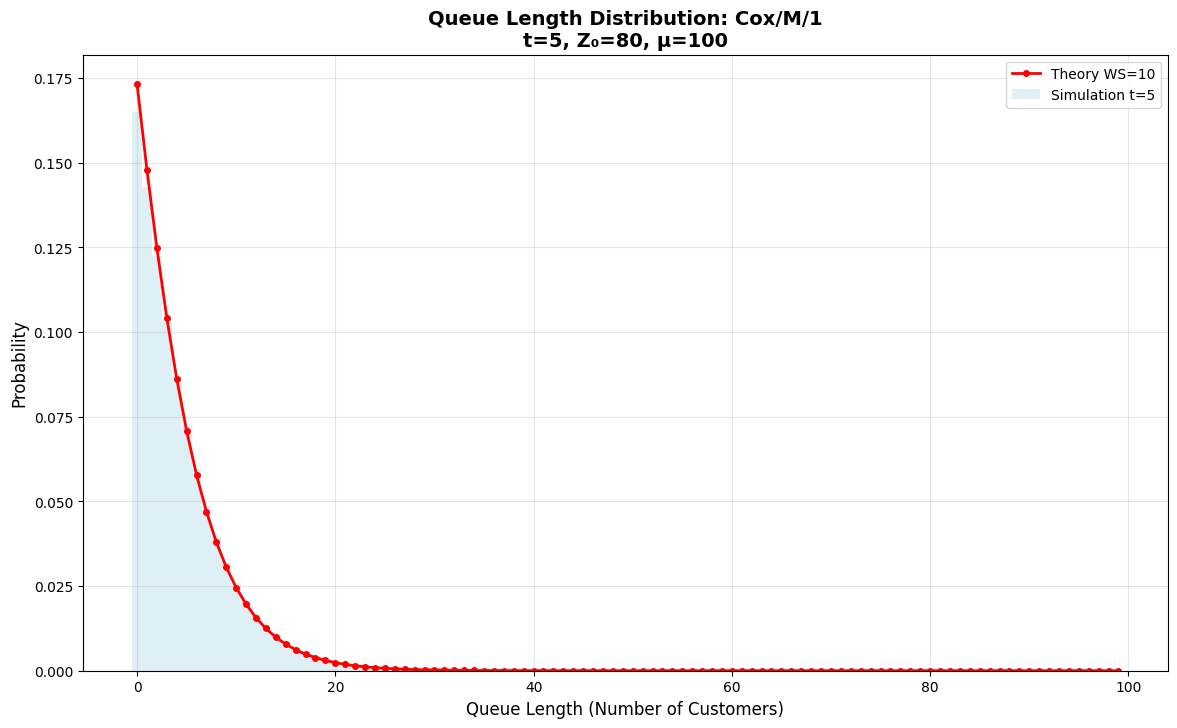

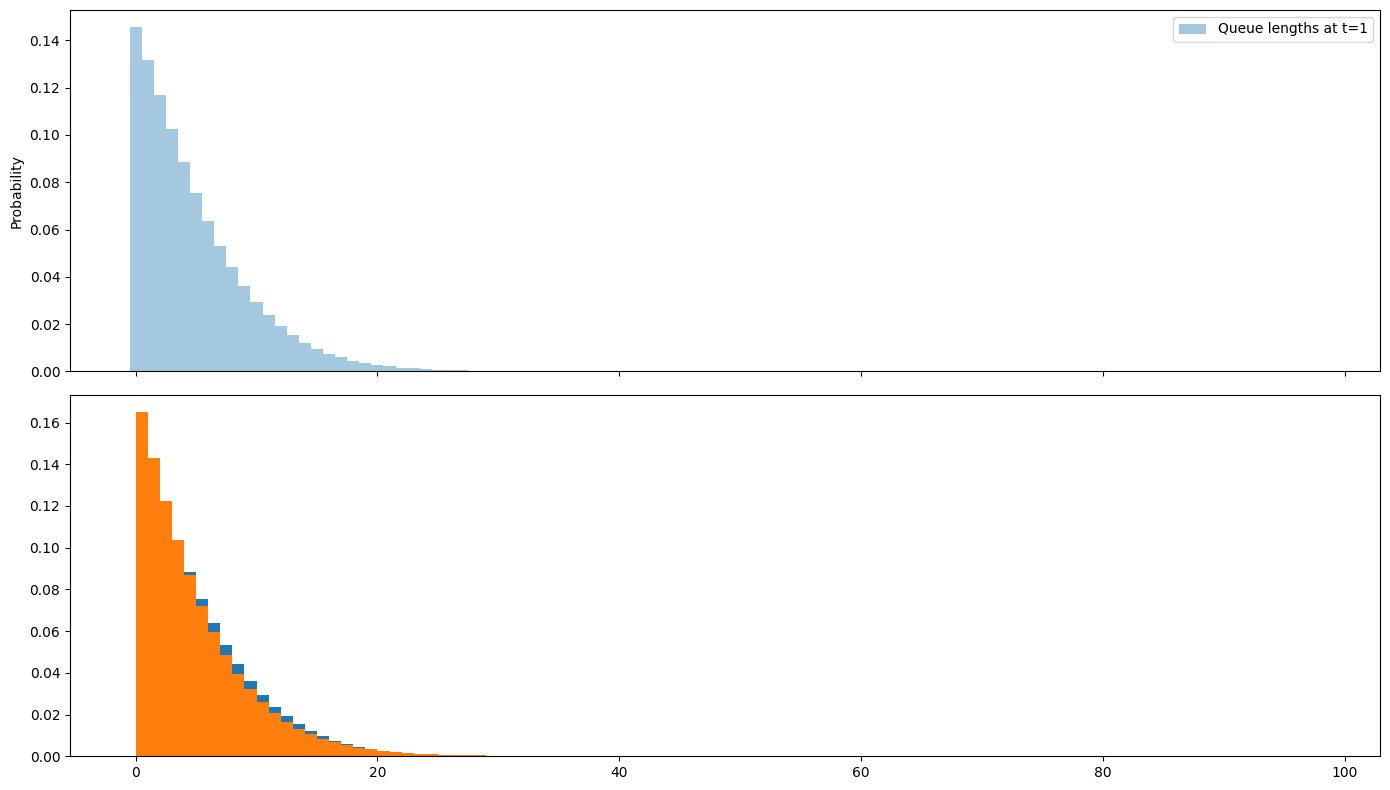

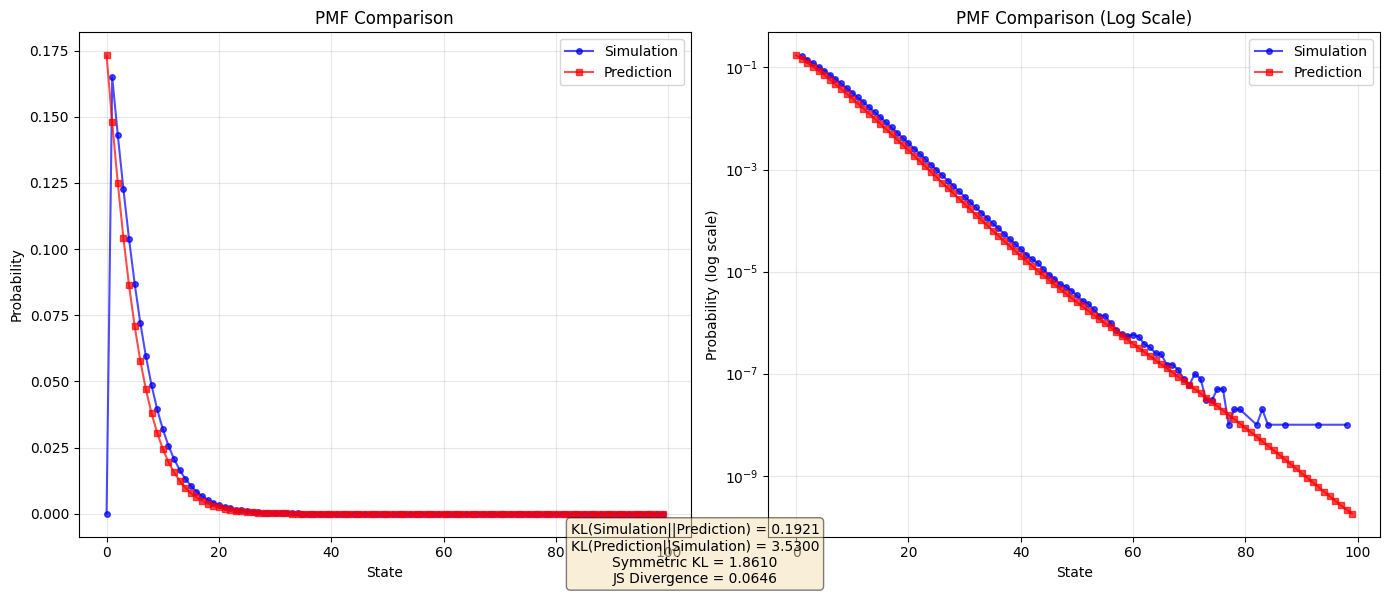

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_kalman_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=80
    min_history_length=10
    method='kalman'
    t=5
    
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print(f"{method}_Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=t,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=100, # max number of states
        show_histogram=True
    )

cpd Predictor


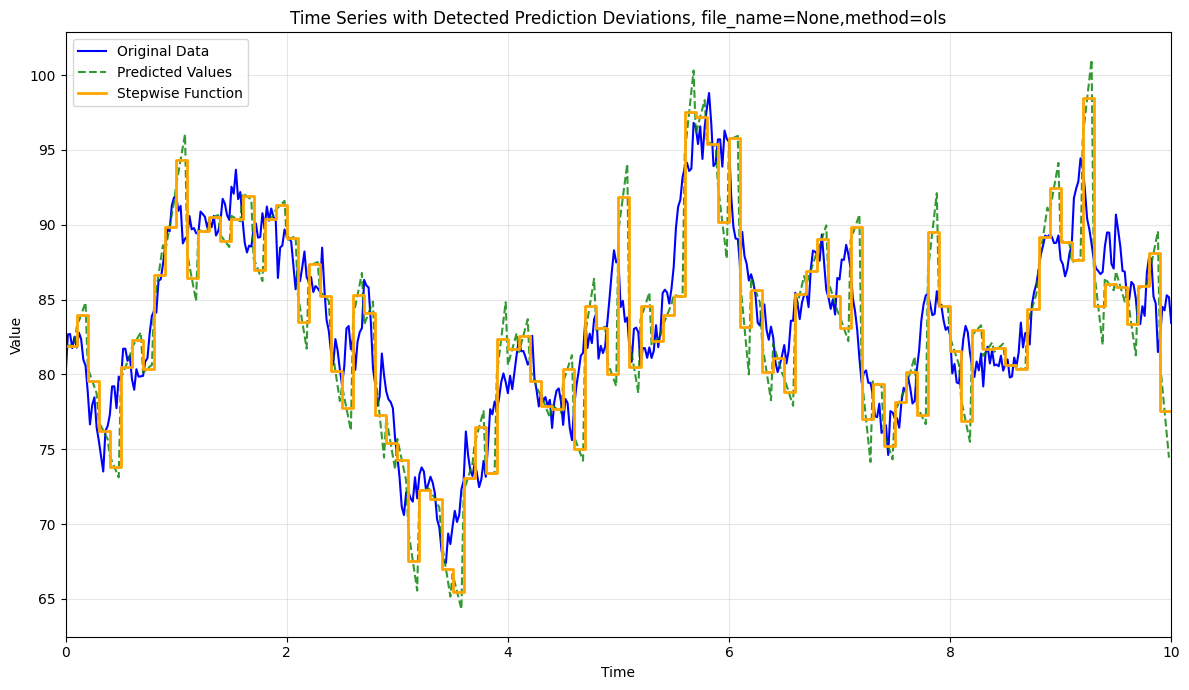


Prediction performance summary
Root mean square error (RMSE): 3.2835
Mean absolute error (MAE): 2.4891
Mean absolute percentage error (MAPE): 2.98%
Direction prediction accuracy: 51.1%
95% confidence interval coverage: 99.8%
Successfully predicted points: 500

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
(501,) (501,)
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t1.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.145588]
  Bins range: [0.0, 60.0]
length of bins: 61, length of counts: 60
✓ Plotted PMF for window size 5
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.139389]
  PMF length: 271, Plotted length: 270


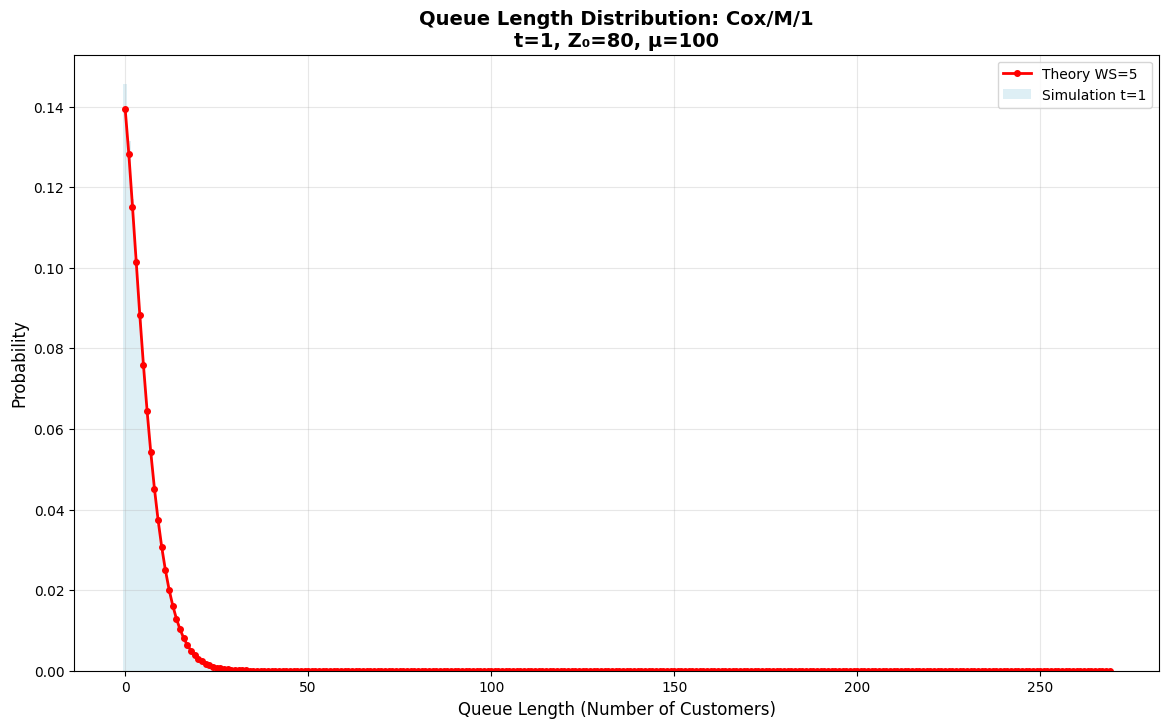

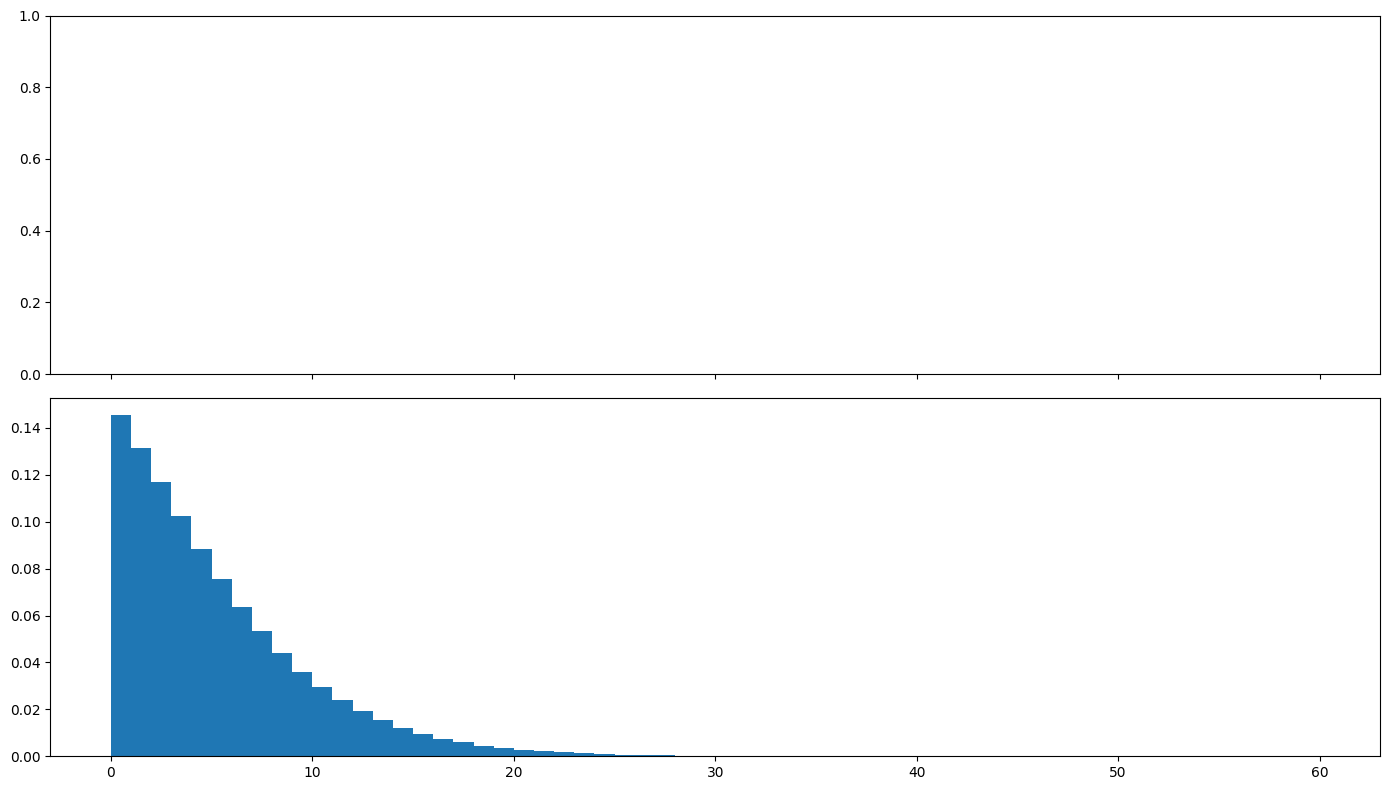

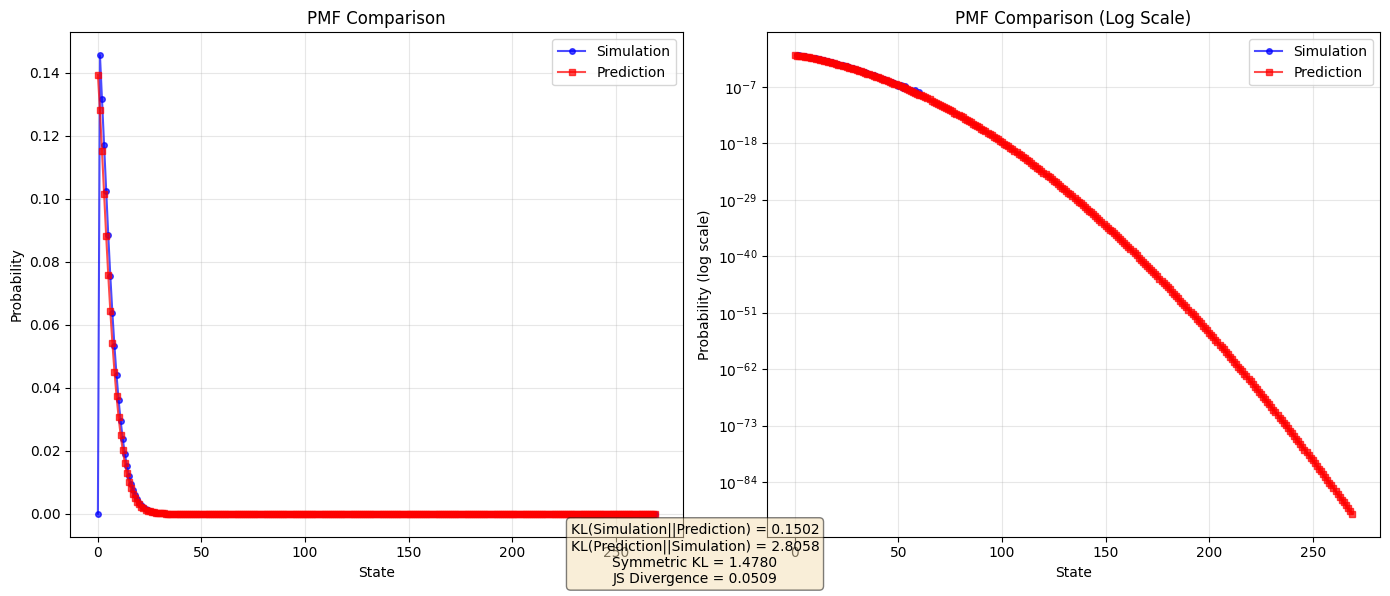

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_cpd_pmf_min_hist_length_10/pmf_overlap_t1.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    #Parameters  for prediction
    z_initial=80
    min_history_length=10
    ws=5
    method='cpd'
    t=1
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )

# Z0=80,t=1

kalman_Predictor
Rolling prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=81.43, Actual=78.82, Error=-2.61
Time 0.220: Predicted=80.47, Actual=76.67, Error=-3.81
Time 0.240: Predicted=79.00, Actual=77.95, Error=-1.04
Time 0.260: Predicted=78.60, Actual=78.47, Error=-0.13
Time 0.280: Predicted=78.59, Actual=76.48, Error=-2.11
Successfully predicted: 491 points


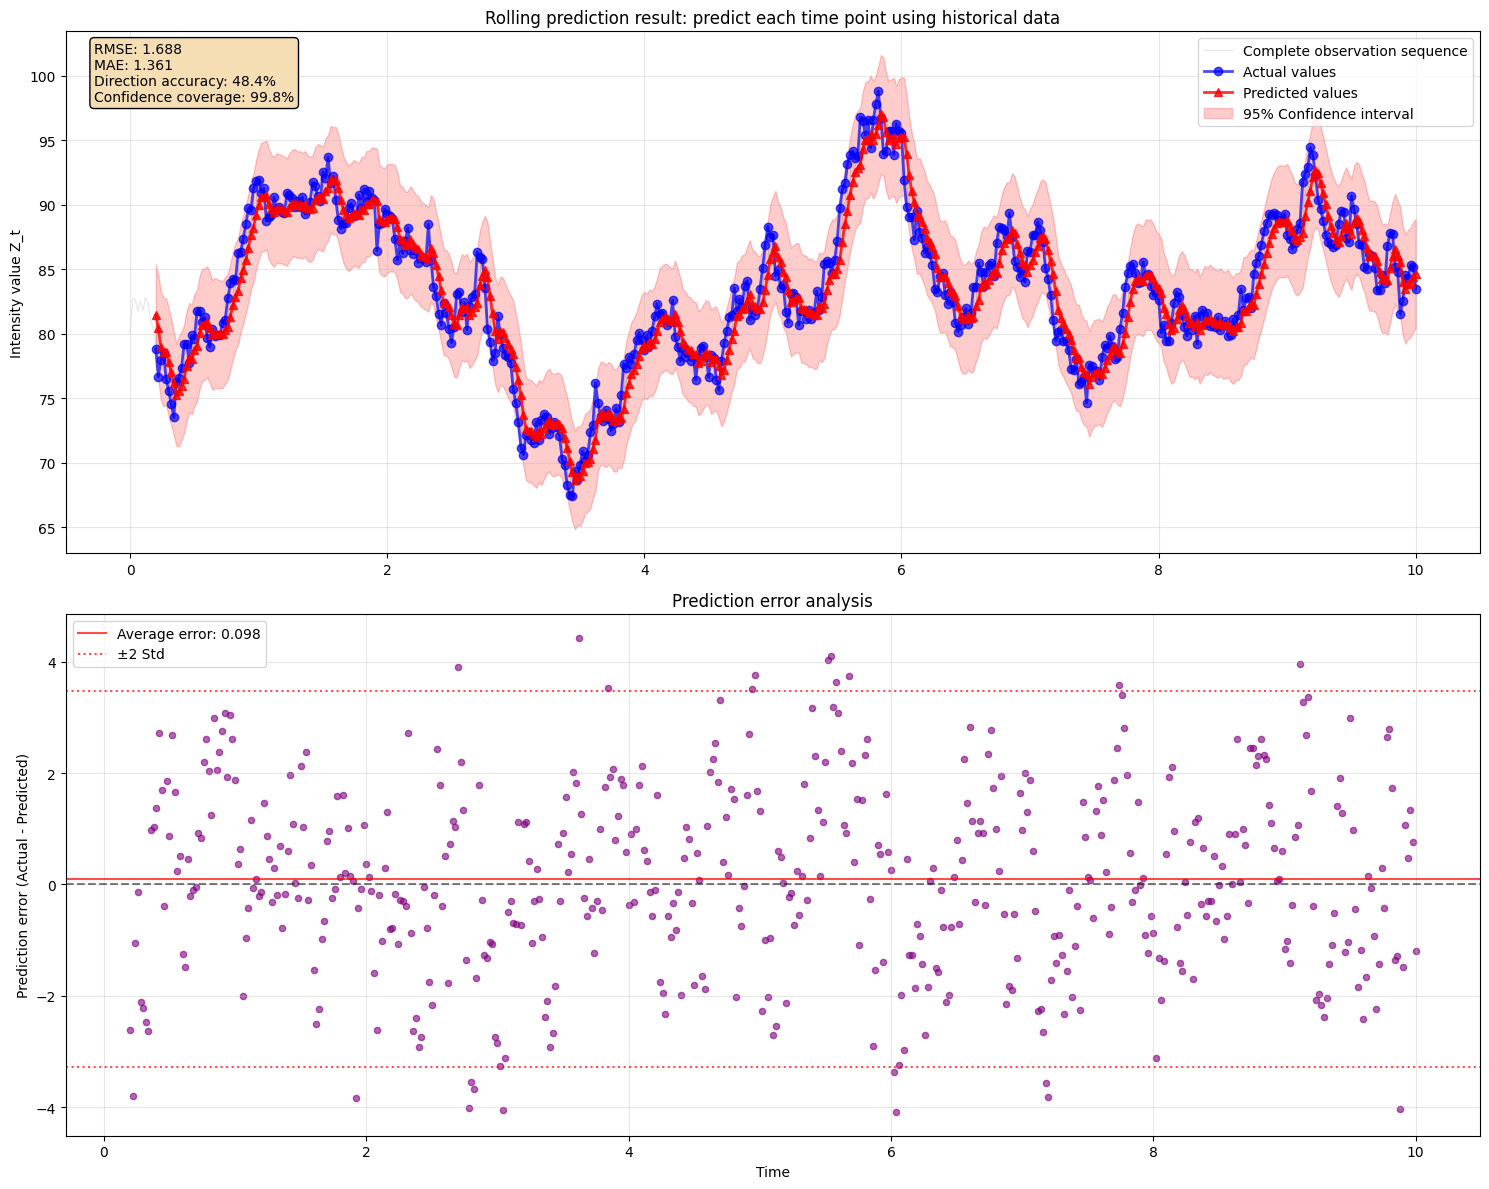


Prediction performance summary
Root mean square error (RMSE): 1.6882
Mean absolute error (MAE): 1.3606
Mean absolute percentage error (MAPE): 1.63%
Direction prediction accuracy: 48.4%
95% confidence interval coverage: 99.8%
Successfully predicted points: 491

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t1.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.145588]
  Bins range: [0.0, 60.0]
length of bins: 61, length of counts: 60
✓ Plotted PMF for window size 10
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.155772]
  PMF length: 101, Plotted length: 100


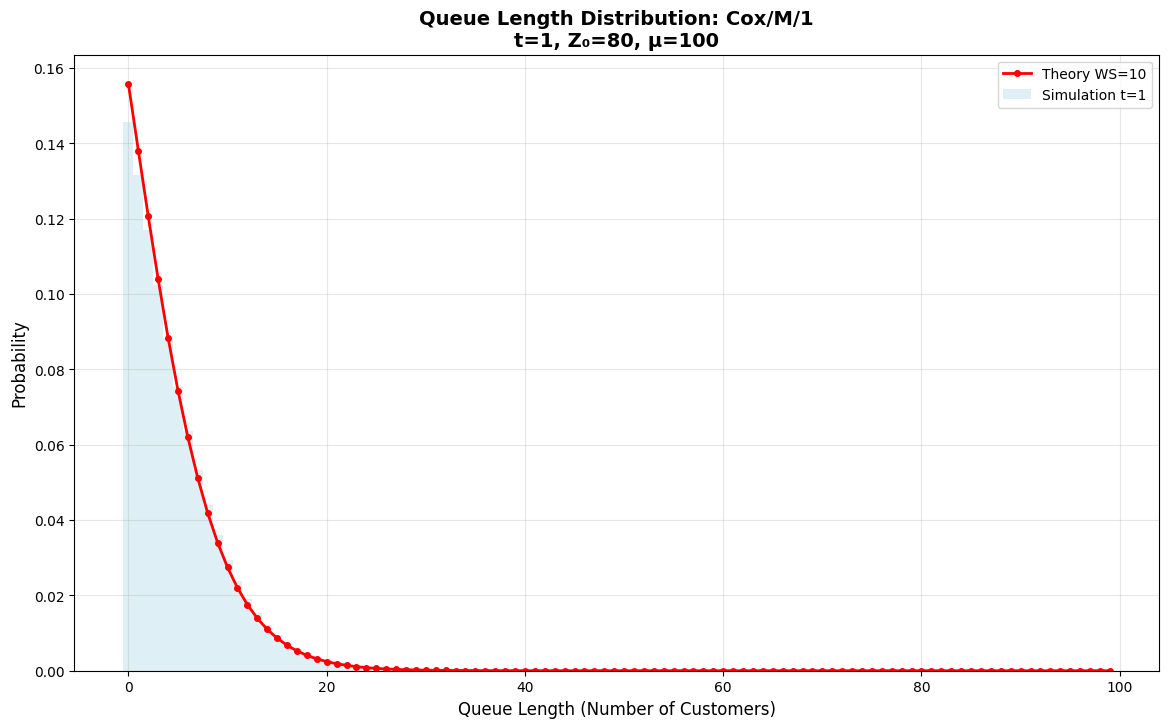

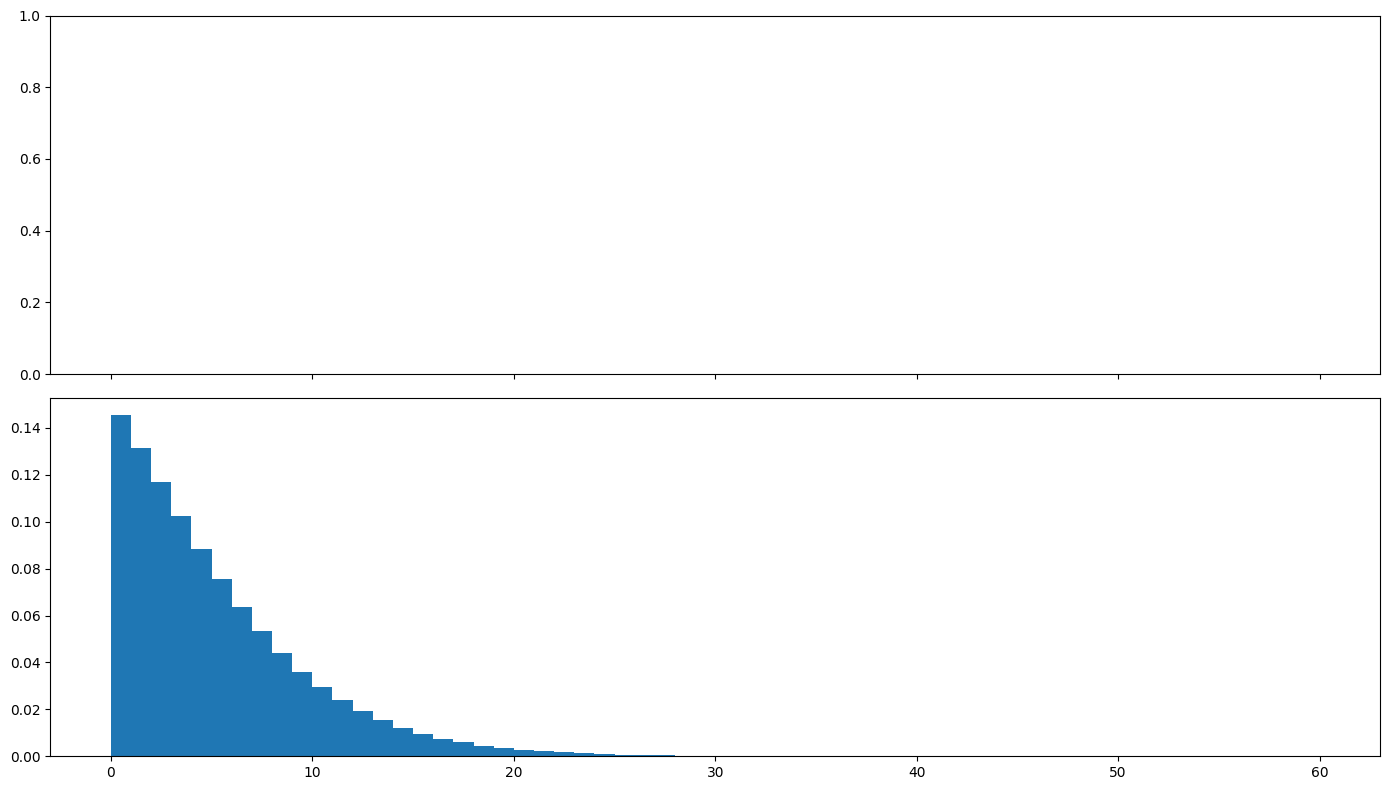

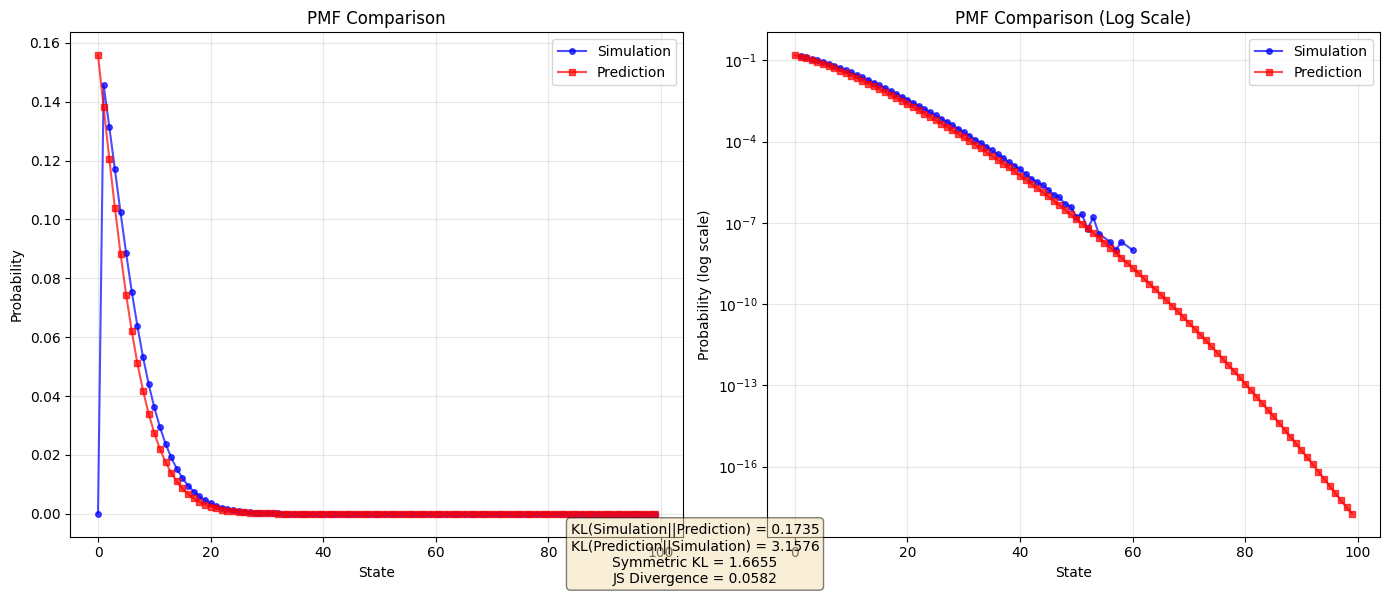

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_kalman_pmf_min_hist_length_10/pmf_overlap_t1.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=80
    min_history_length=10
    method='kalman'
    t=1
    
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print(f"{method}_Predictor")
 
    # Execute rolling prediction

    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=t,
        file_path=file_path_prediction,   
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=100, # max number of states
        show_histogram=True
    )

# Z0=80,t=5

kalman Predictor
Rolling prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=81.43, Actual=78.82, Error=-2.61
Time 0.220: Predicted=80.47, Actual=76.67, Error=-3.81
Time 0.240: Predicted=79.00, Actual=77.95, Error=-1.04
Time 0.260: Predicted=78.60, Actual=78.47, Error=-0.13
Time 0.280: Predicted=78.59, Actual=76.48, Error=-2.11
Successfully predicted: 491 points


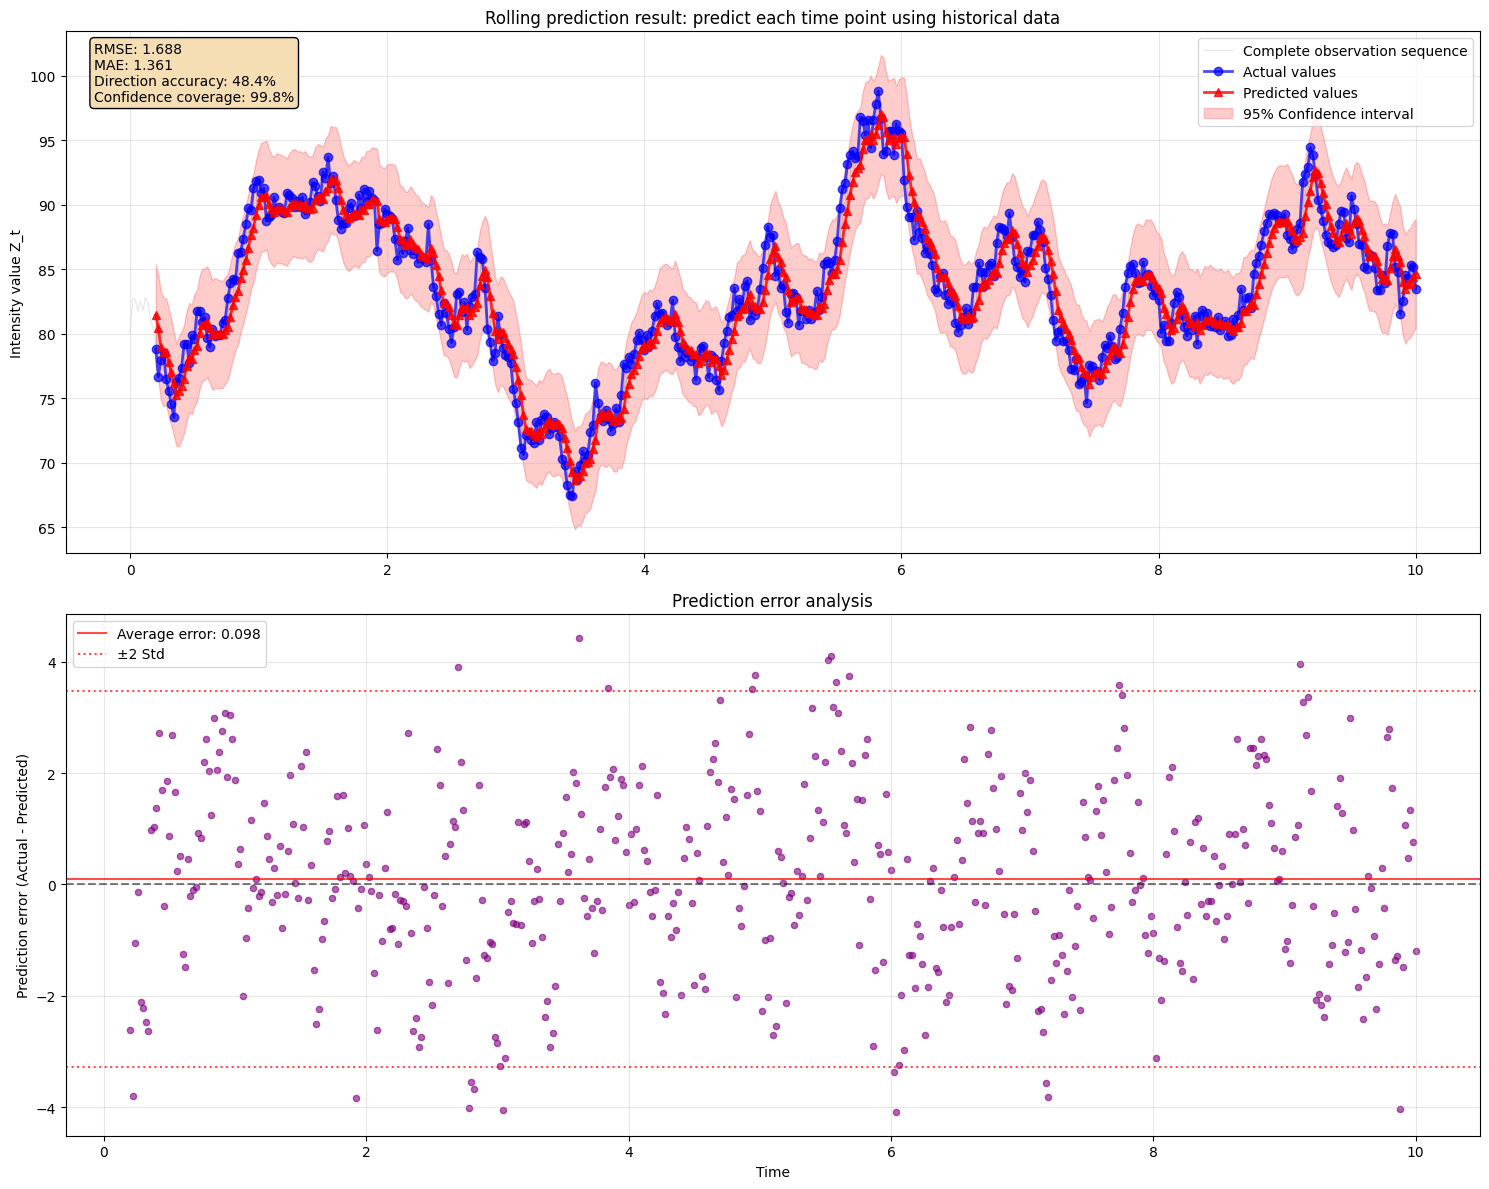


Prediction performance summary
Root mean square error (RMSE): 1.6882
Mean absolute error (MAE): 1.3606
Mean absolute percentage error (MAPE): 1.63%
Direction prediction accuracy: 48.4%
95% confidence interval coverage: 99.8%
Successfully predicted points: 491

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t5.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.164993]
  Bins range: [0.0, 98.0]
length of bins: 99, length of counts: 98
✓ Plotted PMF for window size 15
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.173261]
  PMF length: 271, Plotted length: 270


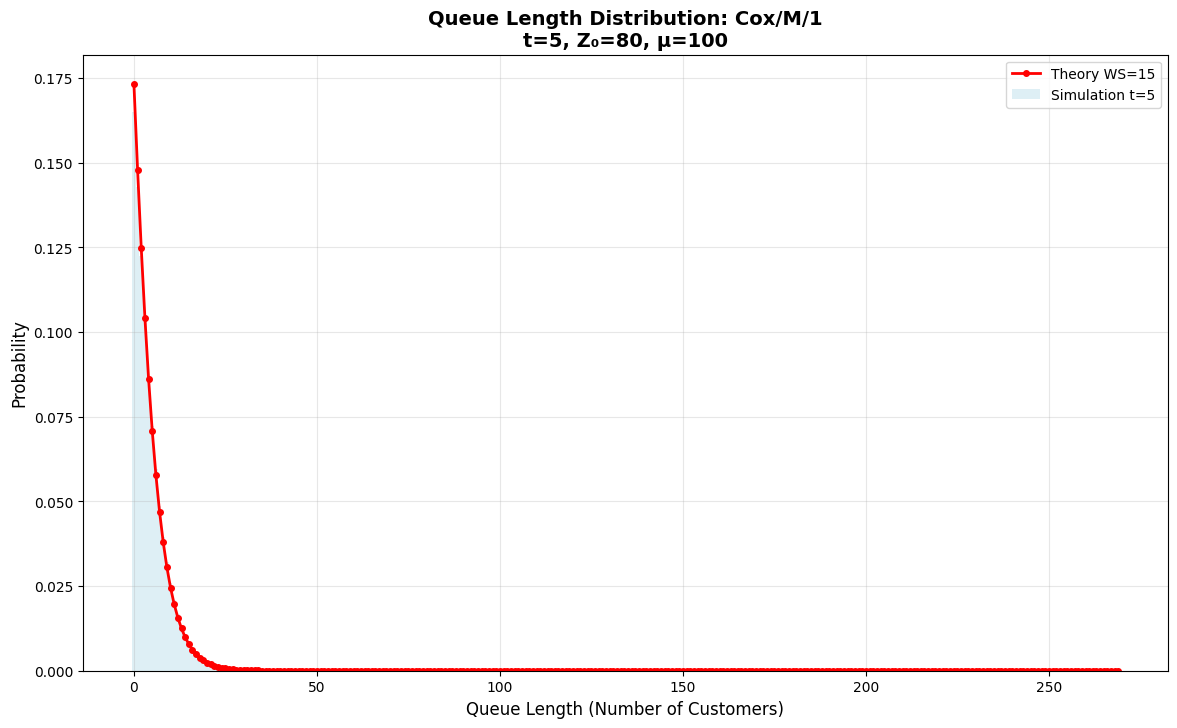

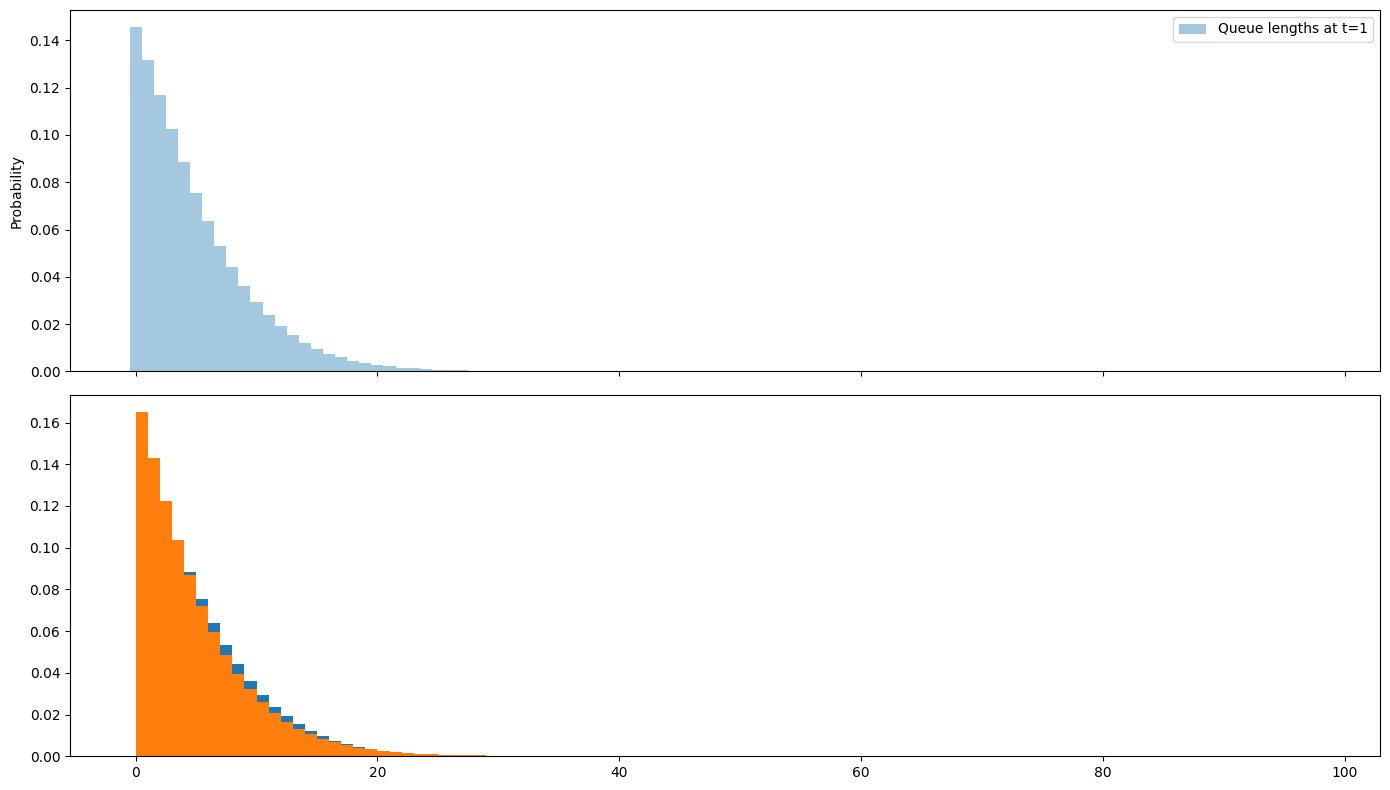

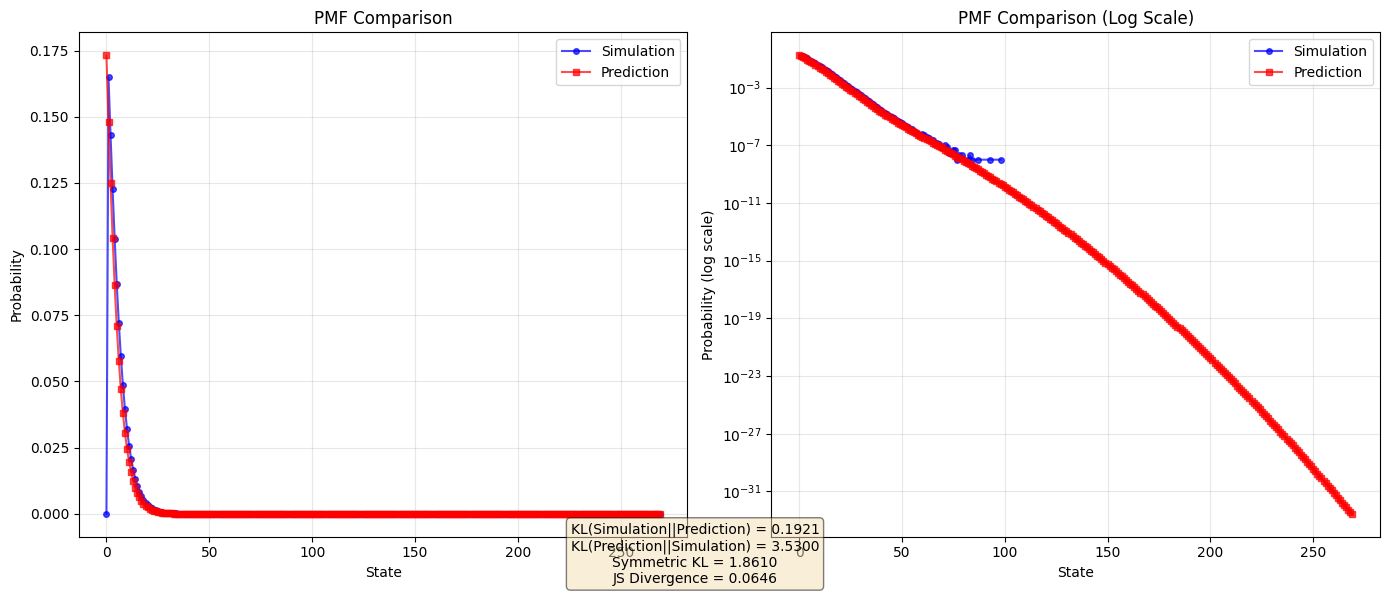

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_kalman_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    #Parameters  for prediction
    z_initial=80
    min_history_length=10
    ws=15
    method='kalman'
    t=5
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    # print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )

cpd_bayesian Predictor
Running online BOCPD...
Processed 1/501 points, current CP prob: 0.0500
Processed 51/501 points, current CP prob: 0.0500
Processed 101/501 points, current CP prob: 0.0500
Processed 151/501 points, current CP prob: 0.0500
Processed 201/501 points, current CP prob: 0.0500
Processed 251/501 points, current CP prob: 0.0500
Processed 301/501 points, current CP prob: 0.0500
Processed 351/501 points, current CP prob: 0.0500
Processed 401/501 points, current CP prob: 0.0500
Processed 451/501 points, current CP prob: 0.0500
Processed 501/501 points, current CP prob: 0.0500
Running windowed prediction...
Step 30: Max CP probability in window = 0.0500
Change point detected at index 15 with probability 0.0500
Step 45: Max CP probability in window = 0.0500
Change point detected at index 41 with probability 0.0500
Step 60: Max CP probability in window = 0.0500
Change point detected at index 47 with probability 0.0500
Step 75: Max CP probability in window = 0.0500
Change point 

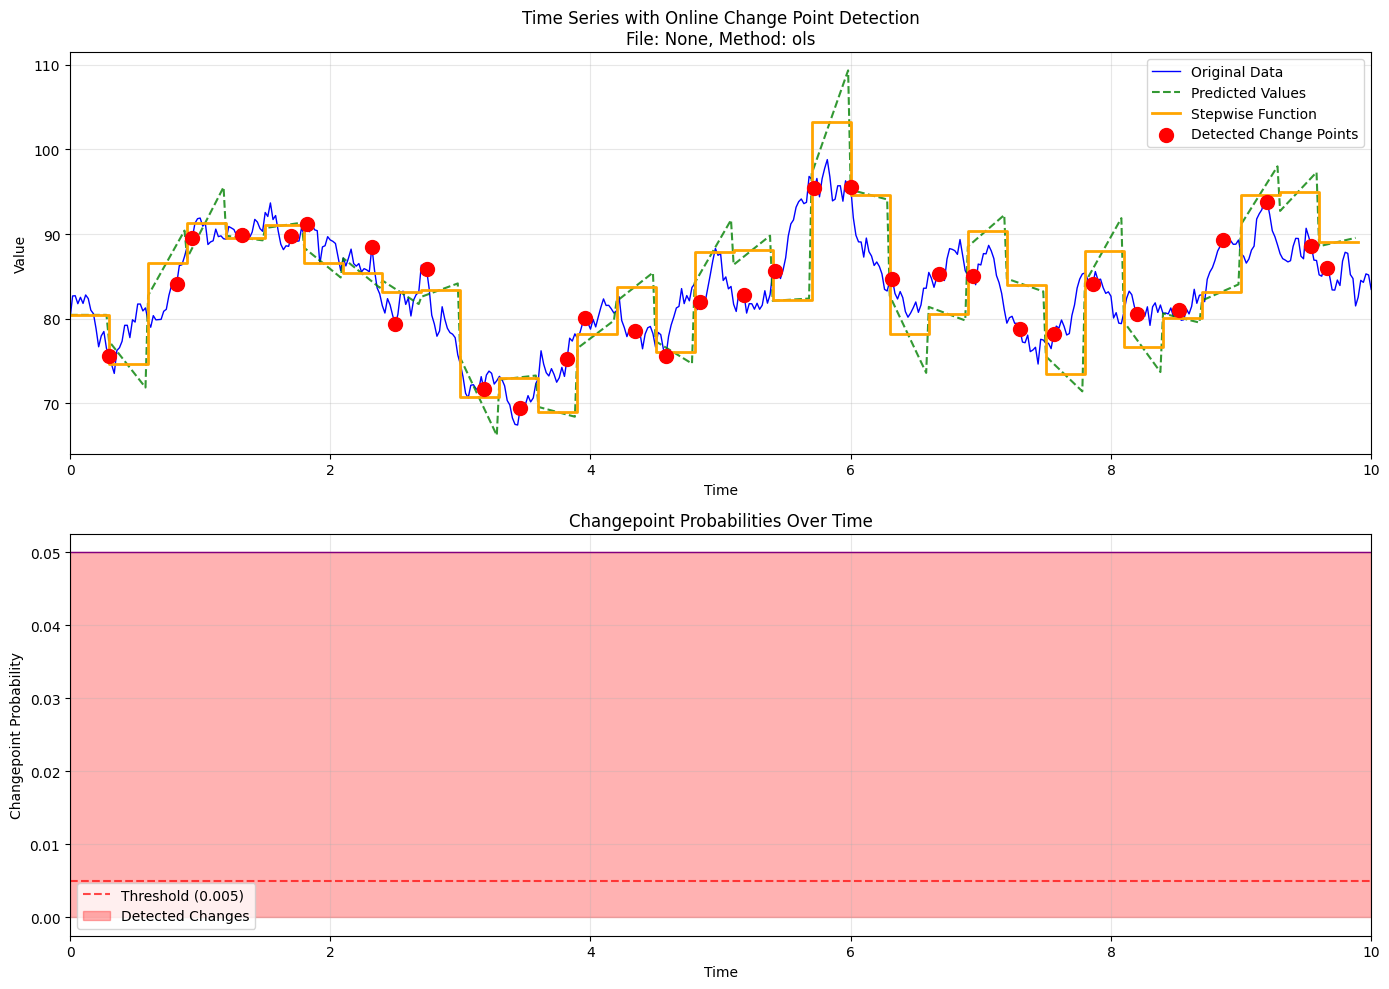


Prediction performance summary
Root mean square error (RMSE): 5.0997
Mean absolute error (MAE): 4.1689
Mean absolute percentage error (MAPE): 5.00%
Direction prediction accuracy: 49.8%
95% confidence interval coverage: 95.0%
Successfully predicted points: 495

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
(501,) (501,)
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t5.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.164993]
  Bins range: [0.0, 98.0]
length of bins: 99, length of counts: 98
✓ Plotted PMF for window size 15
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.155770]
  PMF length: 271, Plotted length: 270


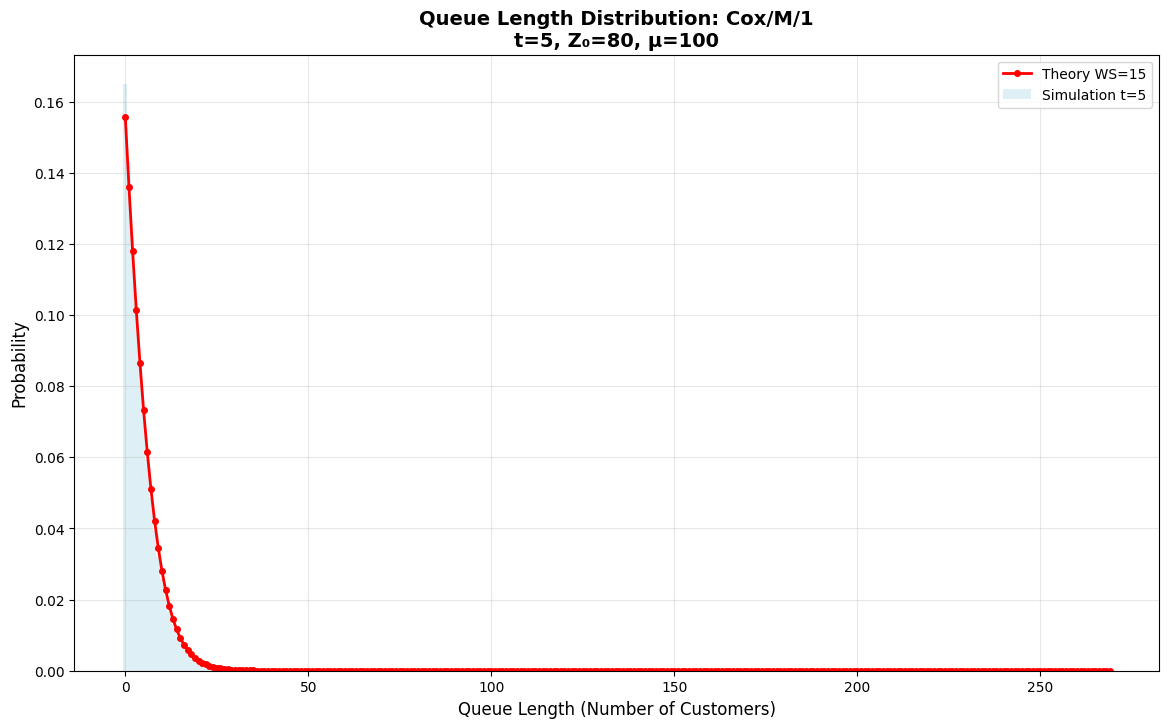

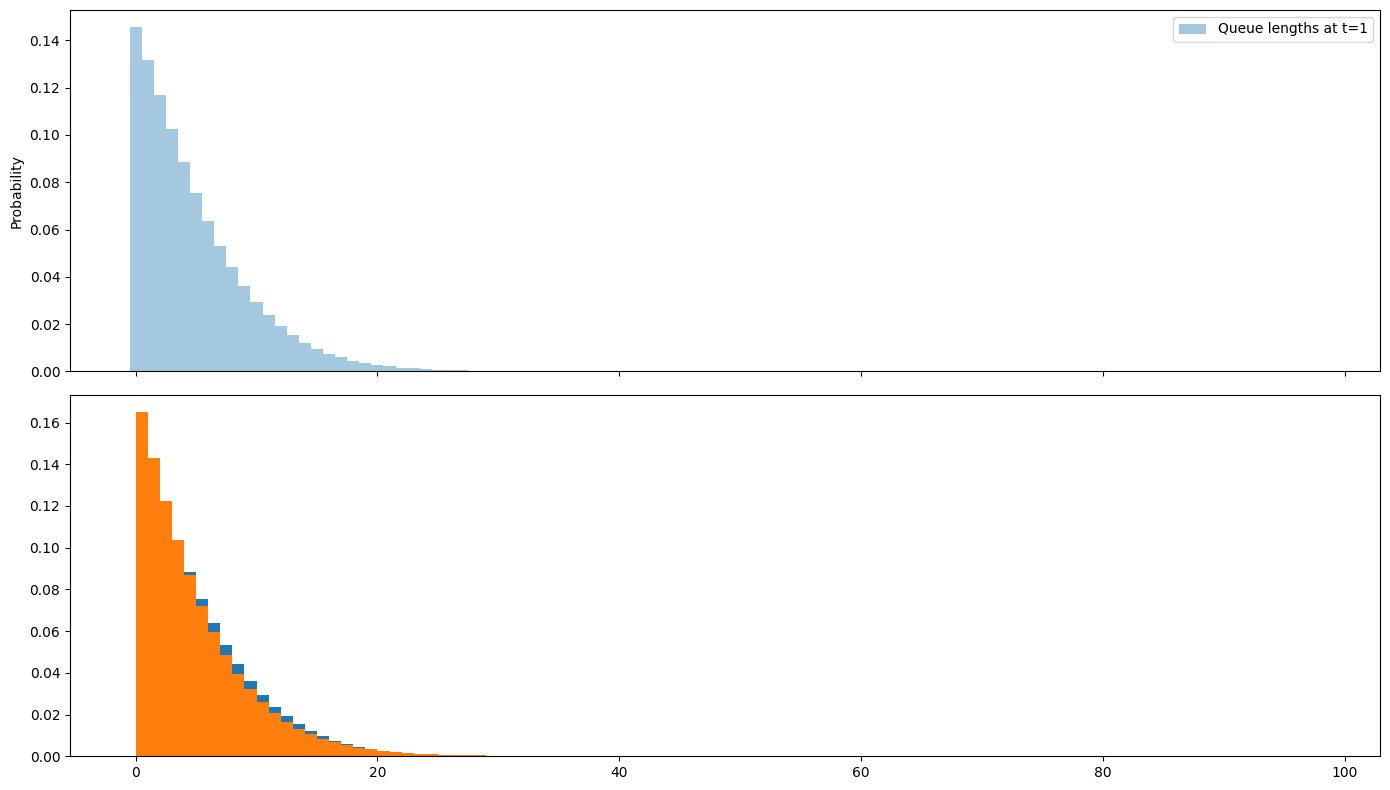

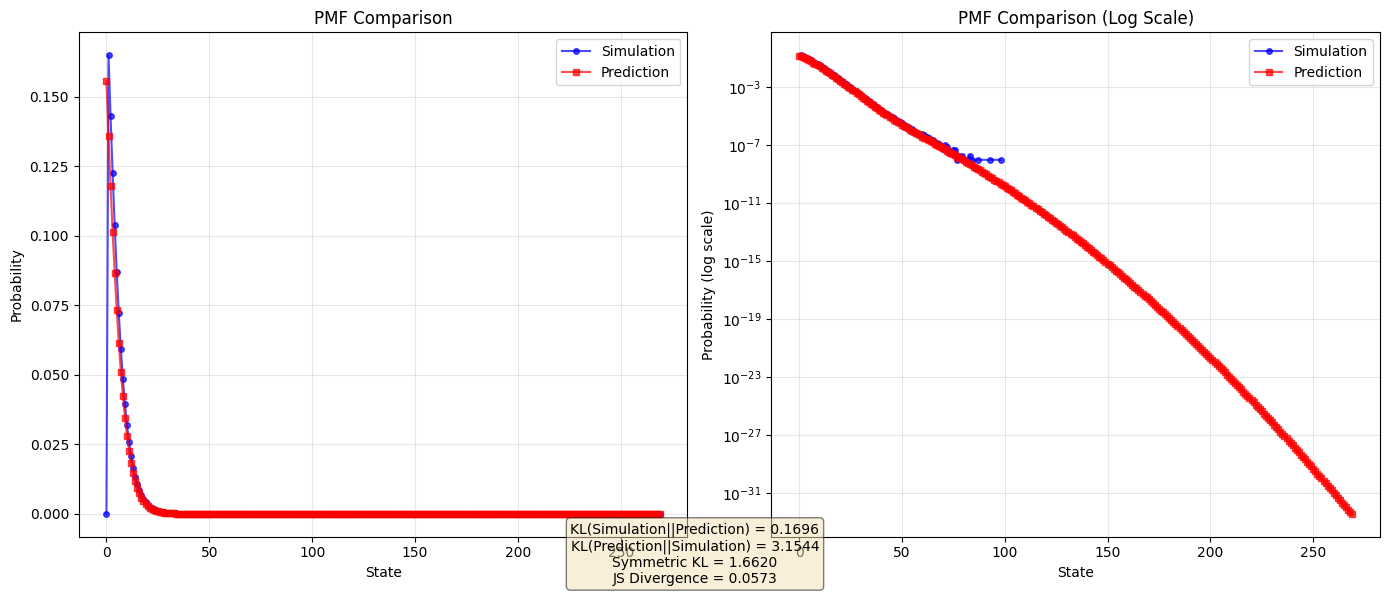

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_cpd_bayesian_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    #Parameters  for prediction
    z_initial=80
    min_history_length=10
    ws=15
    method='cpd_bayesian'
    t=5
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )

cpd Predictor


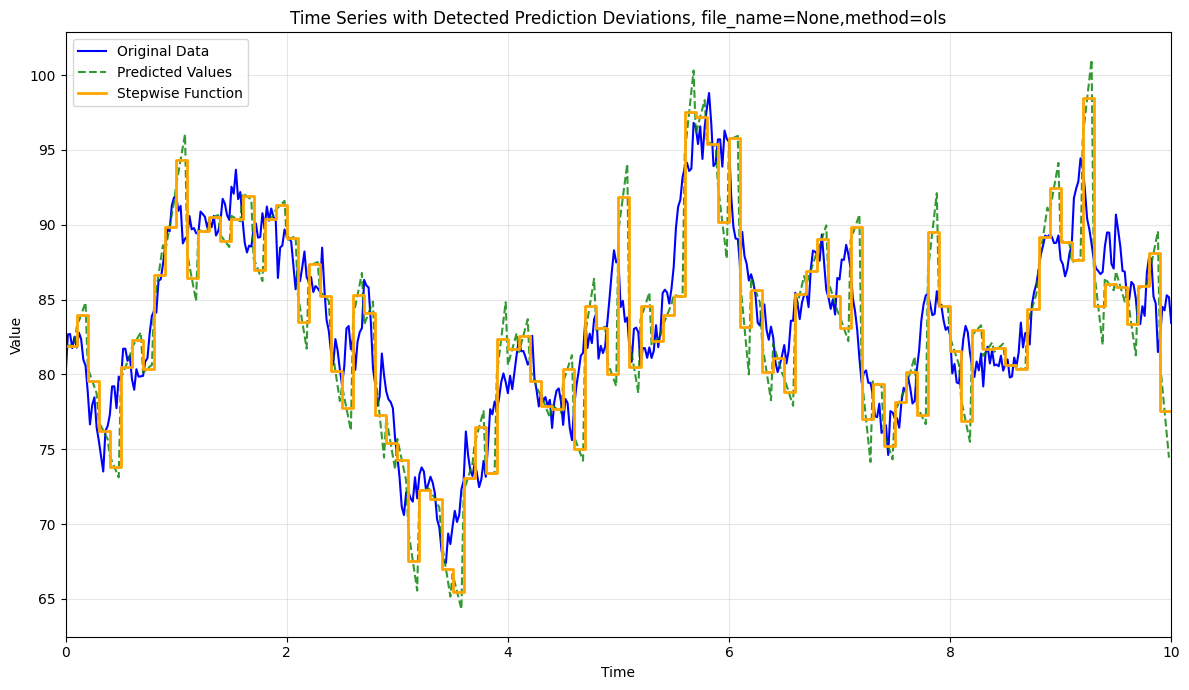


Prediction performance summary
Root mean square error (RMSE): 3.2835
Mean absolute error (MAE): 2.4891
Mean absolute percentage error (MAPE): 2.98%
Direction prediction accuracy: 51.1%
95% confidence interval coverage: 99.8%
Successfully predicted points: 500

Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
(501,) (501,)
✓ Loaded histogram: for_histogram_CoxM1_Z080_serv100_t5.pickle
  Total count: 1.0
  Probability sum: 1.000000
  Histogram range: [0.000000, 0.164993]
  Bins range: [0.0, 98.0]
length of bins: 99, length of counts: 98
✓ Plotted PMF for window size 5
  PMF sum: 1.000000
  Plotted PMF sum: 1.000000
  PMF range: [0.000000, 0.172238]
  PMF length: 271, Plotted length: 270


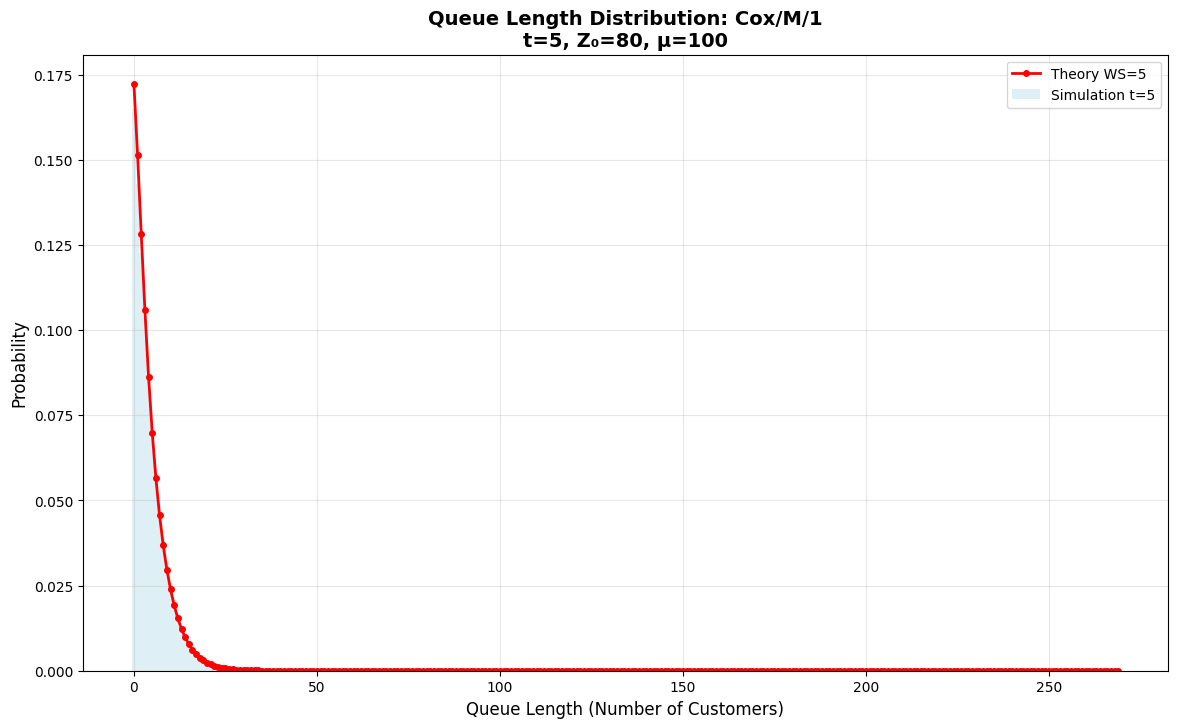

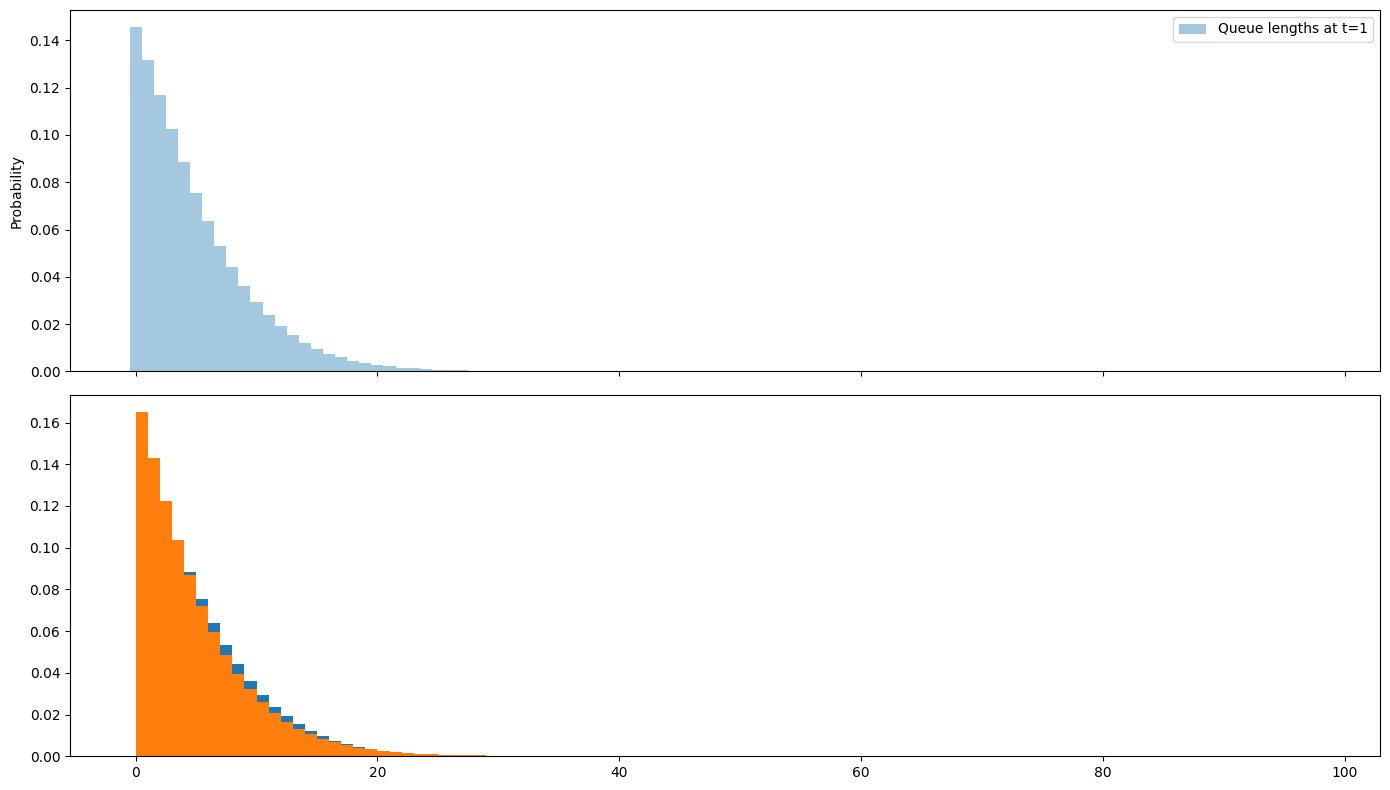

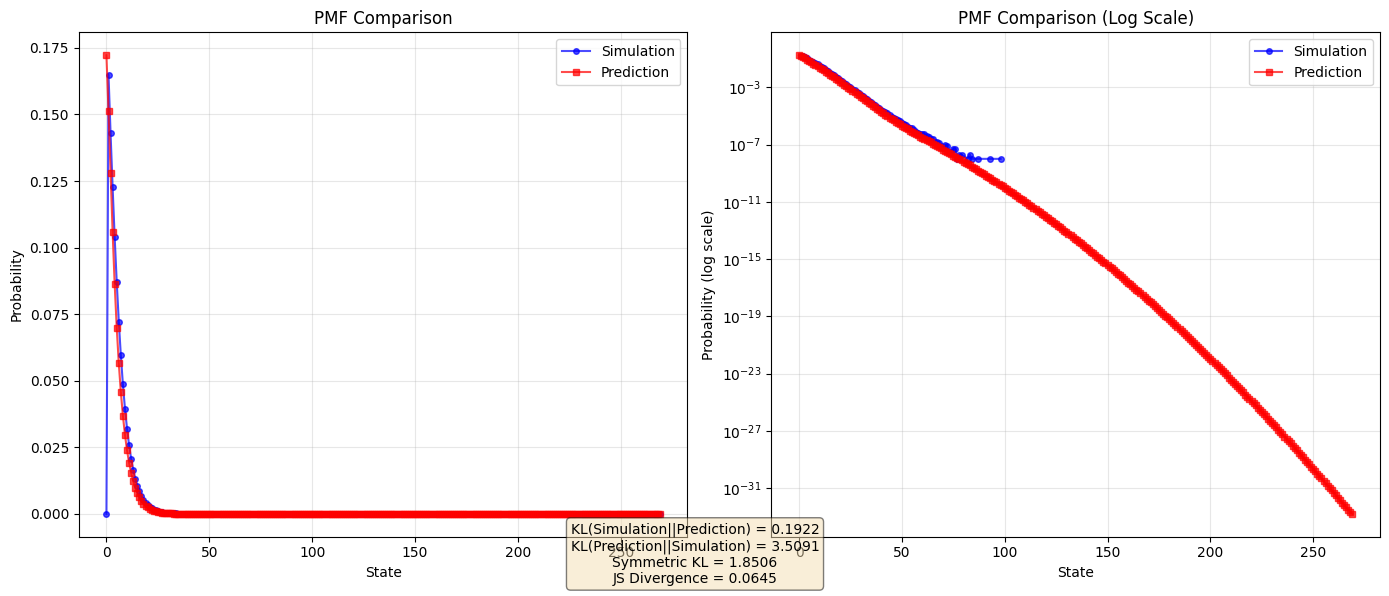

✅ PMF overlap plot saved to /home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_predicted_cpd_pmf_min_hist_length_10/pmf_overlap_t5.png
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    #Parameters  for prediction
    z_initial=80
    min_history_length=10
    ws=5
    method='cpd'
    t=5
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    print(f"{method} Predictor")
    result = rolling_predictor(times, values, min_history_length=min_history_length, verbose=True,method=method,window_size=ws)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_{z_initial}_samples_500_predicted_{method}_min_history_length_{min_history_length}_ws_{ws}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_{z_initial}_samples_500_predicted_{method}_pmf_min_hist_length_{min_history_length}/'   

    print((result['detailed_results']['predicted_step_function_time_interval'].shape),(result['detailed_results']['predicted_step_function'].shape))
    plot_pmf_overlap(
        [ws],
        t=t,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=270, # max number of states
        show_histogram=True
    )